In [1]:
import numpy as np
import math

import struct
import os

from tqdm import tqdm

import snntorch as snn
import torch
import torch.nn as nn

import snntorch.spikeplot as splt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics.classification import MulticlassConfusionMatrix

from snntorch import surrogate
import snntorch.functional as SF
import torch.nn.functional as F
from torch.nn import NLLLoss, LogSoftmax

from snntorch import spikegen

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import snntorch.spikeplot as splt
import imageio

from sklearn.metrics import ConfusionMatrixDisplay

from itertools import accumulate

from collections.abc import Iterable

from copy import deepcopy

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
import visualize
import dataset as ds

## Constants

In [3]:
nCublets = 1000
nSensors = 100
max_t = 20
dt = 0.2
timesteps = int(max_t/dt)

In [4]:
labels_map = {
  -1: "unclassified",
   0: "proton",
   1: "kaon",
   2: "pion",
   3: "other"
}
nClasses = len(labels_map)-1

# SNN Classes

## SNN Definition

In [5]:
class Spiking_Net(nn.Module):
    """FCN with variable neural model and number of layers."""

    def __init__(self, net_desc, spikegen_fn):
        super().__init__()
        
        self.n_neurons = net_desc["layers"]
        self.timesteps = net_desc["timesteps"]
        self.output = net_desc["output"]

        modules = []
        for i_layer in range(1, len(self.n_neurons)):
            modules.append(nn.Linear(in_features=self.n_neurons[i_layer-1], out_features=self.n_neurons[i_layer]))
            if "model" in net_desc:
                modules.append(net_desc["model"](**net_desc["neuron_params"][i_layer]))
            else:
                modules.append(net_desc["neuron_params"][i_layer][0](**(net_desc["neuron_params"][i_layer][1])))
        self.network = nn.Sequential(*modules)

        self.spikegen_fn = spikegen_fn

    
    def forward(self, data):
        """Forward pass for several time steps."""

        x = self.spikegen_fn(data)

        # Initalize membrane potential
        mem = []
        for i, module in enumerate(self.network):
            if i%2==1:
                res = module.reset_mem()
                if type(res) is tuple:
                    mem.append(list(res))
                else:
                    mem.append([res])

        # Record the final layer
        spk_rec = []
        mem_rec = []

        # Loop over 
        spk = None
        for step in range(self.timesteps):
            for i_layer in range(len(self.network)//2):
                if i_layer == 0:
                    cur = self.network[2*i_layer](x[step])
                else:
                    cur = self.network[2*i_layer](spk)
                
                spk, *(mem[i_layer]) = self.network[2*i_layer+1](cur, *(mem[i_layer]))

                if i_layer == len(self.network)//2-1:
                    spk_rec.append(spk)
                    mem_rec.append(mem[i_layer][-1])

        if self.output == "spike":
            return torch.stack(spk_rec, dim=0)
        elif self.output == "membrane":
            return torch.stack(mem_rec, dim=0)

## Predictor Class 
To compare NN output with targets

In [6]:
from typing import Callable, Union

def predict_membrane(output):
    prediction = output[-1].squeeze(1)
    if len(prediction.shape) > 1:
        prediction = prediction.mean(1)
    return prediction

def predict_spikefreq(output):
    prediction = output.sum(0).mean(1) # sum spikes across time and average over the population
    return prediction

def absolute_distance(prediction, targets, relative: bool = True, transform: Callable = lambda *args, **kwargs: args[0]):
    p, t = transform(prediction), transform(targets)
    accuracy = torch.abs(t - p)
    if relative:
        accuracy /= t
    return accuracy

def distance(prediction, targets, relative: bool = True, transform: Callable = lambda *args, **kwargs: args[0]):
    p, t = transform(prediction), transform(targets)
    accuracy = t - p
    if relative:
        accuracy /= t
    return accuracy

def antitransform(x):
    a = x.clone() 
    a[:, 0] = torch.pow(10, a[:,0])
    return a


class Predictor():

    def __init__(self, prediction_fn, accuracy_fn, population_sizes: Union[int, Iterable[int]] = -1):
        self.prediction_fn = prediction_fn
        self.accuracy_fn = accuracy_fn
        if isinstance(population_sizes, int):
            self.population_sizes = population_sizes
            return
        if isinstance(population_sizes, Iterable):
            if isinstance(population_sizes, (np.ndarray, torch.Tensor)):
                population_sizes = population_sizes.tolist()
            if all(isinstance(x, int) for x in population_sizes):
                self.population_sizes = population_sizes
                return
        raise TypeError("Input must be an int or an iterable of int.")


    def _predict_singletask(self, output, targets, reduction: str = "mean"):
        prediction = self.prediction_fn(output)
        accuracy = self.accuracy_fn(prediction, targets)
        if reduction == "mean":
            return prediction, torch.mean(accuracy, 0)
        elif reduction == "sum":
            return prediction, torch.sum(accuracy, 0)
        else:
            return prediction, accuracy
        
    
    def __call__(self, output, targets, reduction: str = "mean"):
        #check if multiple task must be handled
        if len(targets.shape) == 1:
            return self._predict_singletask(output, targets, reduction)
        
        # populations of different size
        if isinstance(self.population_sizes, (list, tuple)):
            if sum(self.population_sizes) != output.shape[-1]:
                raise ValueError("Population sizes must add up to last layer size!")
            if len(self.population_sizes) != targets.shape[-1]:
                raise ValueError("Number of populations must be equal to number of tasks!")
            prediction = torch.zeros(size=targets.shape)
            if reduction == "none":
                accuracy = torch.zeros(size=targets.shape)
            else:
                accuracy = torch.zeros(size=(targets.shape[1],))
            chunks = list(accumulate([0]+list(self.population_sizes)))
            for i, _ in enumerate(self.population_sizes):
                if reduction == "none":
                    prediction[:, i], accuracy[:, i] = \
                        self._predict_singletask(output[chunks[i]:chunks[i+1]], targets[:, i], reduction)
                else:
                    prediction[:, i], accuracy[i] = \
                        self._predict_singletask(output[chunks[i]:chunks[i+1]], targets[:, i], reduction)
            return  prediction, accuracy          

        # populations of the same size
        if isinstance(self.population_sizes, int):
            output = output.reshape(output.shape[0], output.shape[1], self.population_sizes, -1)
            if output.shape[-1] != targets.shape[-1]:
                raise ValueError("Number of populations must be equal to number of tasks!")
        return self._predict_singletask(output, targets, reduction)

## Loss Function

In [7]:
class multi_MSELoss(torch.nn.Module):

    def __init__(self, reduction: str = "mean", weights : torch.tensor = torch.ones(1)) -> None:
        super(multi_MSELoss, self).__init__()
        self.reduction = reduction
        self.weights = weights

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        
        if len(target.shape) < 2:
            target = target.unsqueeze(-1)

        losses = torch.zeros(target.shape[-1])
        for i in range(target.shape[-1]):
            losses[i] = F.mse_loss(input[:, i], target[:, i], reduction=self.reduction)
        
        return (self.weights*losses).sum()

## Trainer Class
For training and testing on datasets

In [8]:
class Trainer():

    def __init__(self, net, loss_fn, optimizer, predict,
                 train_dataset, val_dataset, test_dataset, task="Regression"):
        self.net = net
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.predict = predict    
        self.datasets = {"train": train_dataset, "validation": val_dataset, "test": test_dataset}
        self.task = task

        self.current_epoch = 0
        self.loss_hist = {"train": {}, "validation": {}, "test": {}}
        self.acc_hist = {"validation": {}, "test": {}}


    def test(self, dataset_name):

        # by default, computes accuracy on test dataset
        try:
            if dataset_name == "validation" or dataset_name == "test":
                dataset = self.datasets[dataset_name]
            else:
                raise NameError("Unidentified dataset name. Please choose between \"validation\" or \"test\".")
        except NameError as n:
            print(f"Error: {n}")

        temp_loss = []
        temp_acc = []

        self.net.eval()
        with torch.no_grad():
            temp_loss = []
            for data, targets in dataset:
                data = data.to(device)
                targets = targets.to(device)

                # forward pass
                output = self.net(data)
                pred, acc = self.predict(output, targets)

                # compute loss
                loss = self.loss_fn(pred, targets)
                temp_loss.append(loss.item())
                temp_acc.append(acc)

        self.loss_hist[dataset_name][self.current_epoch] = np.mean(temp_loss, 0)
        self.acc_hist[dataset_name][self.current_epoch] = np.mean(temp_acc, 0)


    def train(self, num_epochs, verbosity=1):

        self.net.to(device)

        # Validation
        self.test("validation")
        if verbosity:
            task_metric = "Average Error" if self.task == "Regression" else "Accuracy"
            print(f"Epoch {self.current_epoch}:")
            print(f"Validation Loss = {self.loss_hist['validation'][self.current_epoch]}")
            print(f"Validation {task_metric} = {self.acc_hist['validation'][self.current_epoch]}")
            print("\n-------------------------------\n")

        for epoch in tqdm(range(num_epochs), desc="Epoch"):
            self.net.train()
            # Minibatch training loop
            for data, targets in tqdm(self.datasets["train"], desc="Batches", leave=False):
                data = data.to(device)
                targets = targets.to(device)

                # forward pass
                output = self.net(data)
                pred, _ = self.predict(output, targets)

                # compute loss
                loss_val = self.loss_fn(pred, targets)

                # Gradient calculation + weight update
                self.optimizer.zero_grad()
                loss_val.backward()
                self.optimizer.step()

                # Store loss history for future plotting
                if self.current_epoch in self.loss_hist["train"]:
                    self.loss_hist["train"][self.current_epoch].append(loss_val.item())
                else:
                    self.loss_hist["train"][self.current_epoch] = [loss_val.item()]

            self.current_epoch += 1

            # Validation
            self.test("validation")

            if verbosity:
                print(f"Epoch {self.current_epoch}:")
                print(f"Validation Loss = {self.loss_hist['validation'][self.current_epoch]}")
                print(f"Validation {task_metric} = {self.acc_hist['validation'][self.current_epoch]}")
                print("\n-------------------------------\n")

    
    def plot_loss(self, validation=True, logscale=True):

        loss = [l for l_per_epoch in self.loss_hist["train"].values() for l in l_per_epoch]
        fig = plt.figure(facecolor="w", figsize=(4, 3))
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        if logscale:
            plt.yscale("log")
        plt.plot(loss, label="Training")
        if validation:
            x = [i*len(self.datasets["train"]) for i in self.loss_hist["validation"]]
            plt.plot(x, list(self.loss_hist["validation"].values()), color='orange', marker='o', linestyle='dashed', label="Validation")
        
        plt.legend(loc='upper right')
        plt.show()

    
    def ConfusionMatrix(self, *args, **kwargs):

        cm = MulticlassConfusionMatrix(*args, **kwargs)

        self.net.eval()
        with torch.no_grad():
            for data, targets in self.datasets["test"]:
                data = data.to(device)
                targets = targets.to(device)

                # forward pass
                output = self.net(data)

                # calculate total accuracy
                pred, _ = self.predict(output, targets)
                cm.update(pred, targets)
        
        return cm


    def _get_all(self, transform: Callable = lambda *args, **kwargs: args[0]):
        self.net.eval()
        all_targets = []
        all_predictions = []
        all_accuracy = []
        with torch.no_grad():
            for data, targets in self.datasets["test"]:
                data = data.to(device)
                targets = targets.to(device)

                # forward pass
                output = self.net(data)

                # calculate total accuracy
                pred, acc = self.predict(output, targets, reduction='none')

                all_targets.append(transform(targets))
                all_predictions.append(transform(pred))
                all_accuracy.append(acc)

        all_targets = torch.cat(all_targets, dim=0)
        all_predictions = torch.cat(all_predictions, dim=0)
        all_accuracy = torch.cat(all_accuracy, dim=0)

        if len(all_targets.shape) < 2:
            all_targets = all_targets.unsqueeze(-1)
            all_predictions = all_predictions.unsqueeze(-1)
            all_accuracy = all_accuracy.unsqueeze(-1)

        return all_targets, all_predictions, all_accuracy
    

    def _plot_results(self, targets = torch.tensor([]), predictions = torch.tensor([]),
                      accuracy = torch.tensor([]), plot_type : str = "2D",
                      nbins : int = 50, title : Union[str, list[str]] = "", logscale : bool = False, select : list = [],
                      *args, **kwargs):
        
        n_tasks = max(targets.shape[-1], accuracy.shape[-1])
        if select:
            n_tasks = min(n_tasks, len(select))
        else:
            select = [i for i in range(n_tasks)]
            
        ncols = math.ceil(math.sqrt(n_tasks))
        nrows = math.ceil(n_tasks / ncols)
        
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, facecolor="w", figsize=(5*ncols, 4*nrows),constrained_layout=True)
        if not isinstance(axs, np.ndarray):
            axs = np.array([axs])
            title = [title]
        axs = axs.flatten()

        for i in range(n_tasks):
            # plot 2D histogram of prediction vs targets
            if plot_type == "2D":
                axs[i].set_xlabel("Targets")
                axs[i].set_ylabel("Prediction")
                axs[i].set_title(title[i])
                if logscale:
                    hist = axs[i].hist2d(targets[:, select[i]], predictions[:, select[i]],
                                         nbins, norm=SymLogNorm(*args, **kwargs), cmap='viridis')
                else:
                    hist = axs[i].hist2d(targets[:, select[i]], predictions[:, select[i]], nbins)
                axs[i].plot([0, 1e5], [0, 1e5], color='white', linewidth=1, linestyle='--')

            # plot 1D histogram of residuals
            if plot_type == "1D":
                axs[i].set_xlabel("Residuals")
                axs[i].set_ylabel("Counts")
                axs[i].set_title(title[i])
                hist = axs[i].hist(accuracy[:, select[i]], nbins)

        for i in range(n_tasks, len(axs)):
            fig.delaxes(axs[i])

        if plot_type == "2D":
            # Add a color bar
            if hist:
                cbar = fig.colorbar(hist[3], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
                cbar.set_label("Counts")  # Customize as needed


    def plot_pred_vs_target(self, transform: Callable = lambda *args, **kwargs: args[0], *args, **kwargs):
        targets, predictions, _ = self._get_all(transform=transform)
        self._plot_results(targets=targets, predictions=predictions, plot_type="2D", *args, **kwargs) 


    def plot_residuals(self, transform: Callable = lambda *args, **kwargs: args[0], *args, **kwargs):
        _, _ , accuracy = self._get_all(transform=transform)
        self._plot_results(accuracy=accuracy, plot_type="1D", *args, **kwargs)


    def show_results(self, transform: Callable = lambda *args, **kwargs: args[0], *args, **kwargs):
        print(f"Test loss: {self.loss_hist['test'][self.current_epoch]}")
        print(f"Test relative error: {self.acc_hist['test'][self.current_epoch]*100}%")
        self.plot_loss()
        targets, predictions, accuracy = self._get_all(transform=transform)
        self._plot_results(targets=targets, predictions=predictions, plot_type="2D", *args, **kwargs) 
        self._plot_results(accuracy=accuracy, plot_type="1D", *args, **kwargs)


## Network Descriptions and Spike Encodings

In [9]:
# Network Descriptions

population = 40

net_desc = {
    "layers" : [400, 50, population],
    "timesteps": 100,
    "neuron_params" : {
                1: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True,
                    "spike_grad": surrogate.atan(),
                    }],
                2: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0e20,
                    "learn_threshold": False, 
                    "spike_grad": surrogate.atan(),
                    }]
                }
    }

net_desc_membrane = deepcopy(net_desc)
net_desc_membrane["output"] = "membrane"

net_desc_spikefreq = deepcopy(net_desc)
net_desc_spikefreq["output"] = "spike"
net_desc_spikefreq["neuron_params"][2][1]["threshold"] = 1.0
net_desc_spikefreq["neuron_params"][2][1]["learn_threshold"] = True


# Spike Generation

def _spikegen(data):
    spike_data = data.transpose(0,1) 
    spike_train = torch.where(spike_data > 300, torch.tensor(1), torch.tensor(0)).to(torch.float32) 
    return spike_train

def spikegen_multi(data, multiplicity=4):
    og_shape = data.shape
    spike_data = torch.zeros(og_shape[1], og_shape[0], multiplicity*og_shape[2])
    for i in range(multiplicity):
        condition = data > np.power(10, i+2)
        batch_idx, time_idx, sensor_idx = torch.nonzero(condition, as_tuple=True)
        spike_data[time_idx, batch_idx, multiplicity*sensor_idx+i] = 1

    return spike_data

## Dataset Creation

In [113]:
dataset = ds.build_dataset("../Data/PrimaryOnly/", max_files=100, primary_only=True,
                           target=["energy","centroid","dispersion"])

In [115]:
dataset = ds.build_dataset("../Data/PrimaryOnly/Uniform", max_files=100, primary_only=True,
                           target=["energy","centroid","dispersion"])

In [117]:
dataset = ds.build_dataset("../Data/PrimaryOnly/Centered", max_files=100, primary_only=True,
                           target=["energy","centroid","dispersion"])

## Check Distributions

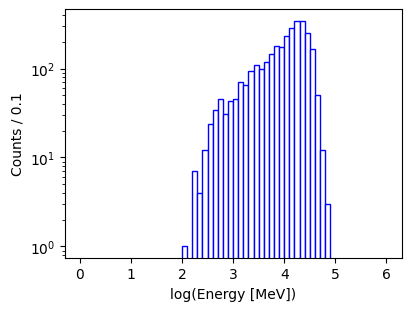

In [118]:
dataset.transform = lambda x: (x[0], ds.to_tensor_and_dtype(np.log10(x[1][0])), torch.float32)
dims=["log(Energy [MeV])"]
fig, axs = plt.subplots(ncols=len(dims), nrows=1, facecolor="w", figsize=(4*len(dims), 3),constrained_layout=True)     
n = 10
bins=np.arange(0, 6+1/n, 1/n)
axs.set_ylabel(f"Counts / {1/n}")
for i in range(len(dims)):    
    energy = np.array([d[1] for d in dataset])
    axs.set_xlabel(dims[i])
    axs.set_yscale("log")
    axs.hist(energy, bins=bins, edgecolor='blue', facecolor='white')


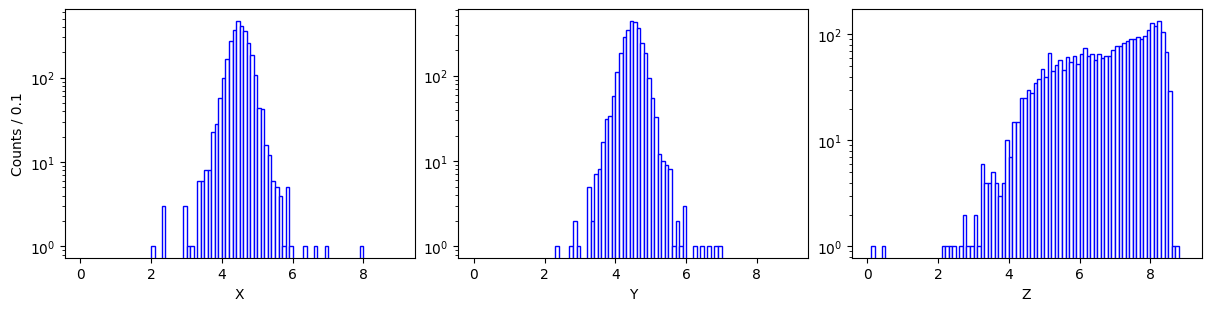

In [ ]:
dataset.transform = lambda x: (x[0], ds.to_tensor_and_dtype(x[1][1]), torch.float32)

dims=["X", "Y", "Z"]
fig, axs = plt.subplots(ncols=len(dims), nrows=1, facecolor="w", figsize=(4*len(dims), 3),constrained_layout=True)     
n = 10
bins=np.arange(0, 9+1/n, 1/n)
axs[0].set_ylabel(f"Counts / {1/n}")
for i in range(len(dims)):    
    positions = np.array([d[1][i] for d in dataset])
    axs[i].set_xlabel(dims[i])
    axs[i].set_yscale("log")
    axs[i].hist(positions, bins=bins, edgecolor='blue', facecolor='white')


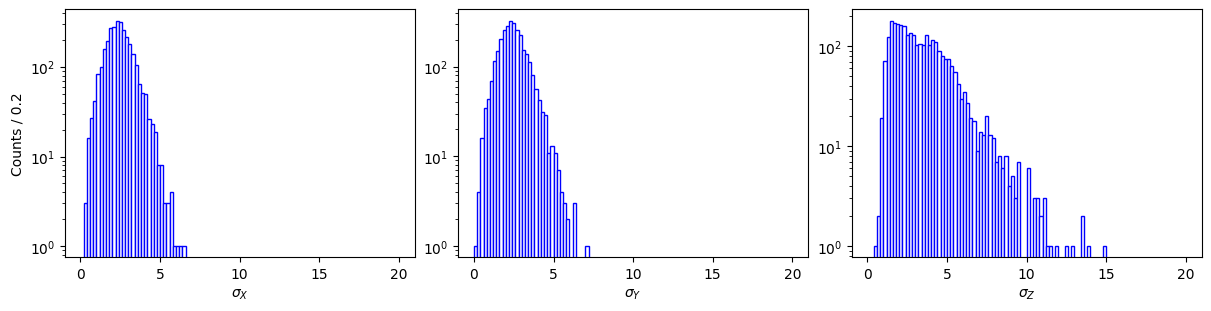

In [103]:
dataset.transform = lambda x: (x[0], ds.to_tensor_and_dtype(x[1][2]), torch.float32)

dims=["X", "Y", "Z"]
fig, axs = plt.subplots(ncols=len(dims), nrows=1, facecolor="w", figsize=(4*len(dims), 3),constrained_layout=True)     
n = 5
bins=np.arange(0, 20+1/n, 1/n)
axs[0].set_ylabel(f"Counts / {1/n}")
for i in range(len(dims)):    
    positions = np.array([d[1][i] for d in dataset])
    axs[i].set_xlabel(rf"$\sigma_{dims[i]}$")
    axs[i].set_yscale("log")
    axs[i].hist(positions, bins=bins, edgecolor='blue', facecolor='white')

# Energy and Position

In [24]:
dataset.transform = lambda x: (x[0], ds.to_tensor_and_dtype([np.log10(x[1][0]), *x[1][1]], torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [25]:
net_Epos_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4)) 
Pred_Epos_spk = Predictor(predict_spikefreq, absolute_distance, population_sizes=10)
loss_Epos = multi_MSELoss(weights=torch.tensor([1,1,1,1]))
opt_Epos_spk = torch.optim.Adam(net_Epos_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_Epos_spk = Trainer(net_Epos_spk, loss_Epos, opt_Epos_spk, Pred_Epos_spk,
                    train_dataset, val_dataset, test_dataset)

In [26]:
num_epochs = 10
train_Epos_spk.train(num_epochs)

Epoch 0:
Validation Loss = 42.82574886745877
Validation Average Error = [0.39822182 1.1259172  0.7231271  0.7767463 ]

-------------------------------



Epoch:  10%|█         | 1/10 [00:06<00:54,  6.07s/it]

Epoch 1:
Validation Loss = 15.492691993713379
Validation Average Error = [0.09108259 0.98536587 0.88296664 0.3214629 ]

-------------------------------



Epoch:  20%|██        | 2/10 [00:11<00:47,  5.94s/it]

Epoch 2:
Validation Loss = 8.557421525319418
Validation Average Error = [0.05541786 0.81476665 0.8268732  0.15454191]

-------------------------------



Epoch:  30%|███       | 3/10 [00:17<00:41,  5.98s/it]

Epoch 3:
Validation Loss = 6.125667625003391
Validation Average Error = [0.05024017 0.5791454  0.7673862  0.13826767]

-------------------------------



Epoch:  40%|████      | 4/10 [00:23<00:35,  5.94s/it]

Epoch 4:
Validation Loss = 4.97951873143514
Validation Average Error = [0.04193772 0.52395797 0.7087006  0.12970105]

-------------------------------



Epoch:  50%|█████     | 5/10 [00:29<00:29,  5.96s/it]

Epoch 5:
Validation Loss = 4.238491614659627
Validation Average Error = [0.03735377 0.46100256 0.59676164 0.12423836]

-------------------------------



Epoch:  60%|██████    | 6/10 [00:35<00:23,  5.96s/it]

Epoch 6:
Validation Loss = 3.8891266187032065
Validation Average Error = [0.03722478 0.4751988  0.5335     0.12229419]

-------------------------------



Epoch:  70%|███████   | 7/10 [00:41<00:17,  5.97s/it]

Epoch 7:
Validation Loss = 3.4894347190856934
Validation Average Error = [0.03525021 0.4383679  0.5213004  0.11703523]

-------------------------------



Epoch:  80%|████████  | 8/10 [00:47<00:12,  6.01s/it]

Epoch 8:
Validation Loss = 3.135973268085056
Validation Average Error = [0.0349616  0.40562442 0.49633884 0.11409242]

-------------------------------



Epoch:  90%|█████████ | 9/10 [00:54<00:06,  6.12s/it]

Epoch 9:
Validation Loss = 3.003336376614041
Validation Average Error = [0.0335419  0.4230161  0.48134777 0.11344707]

-------------------------------



Epoch: 100%|██████████| 10/10 [01:00<00:00,  6.04s/it]

Epoch 10:
Validation Loss = 2.823091506958008
Validation Average Error = [0.03308997 0.37838864 0.44388905 0.1163099 ]

-------------------------------



Test loss: 2.849367141723633
Test relative error: [ 3.4279432 42.25432   43.534904   5.649418 ]%


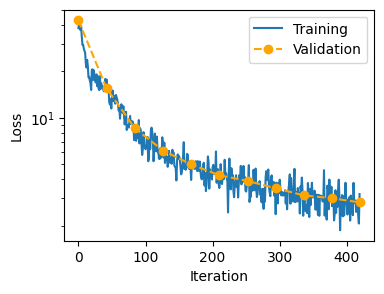

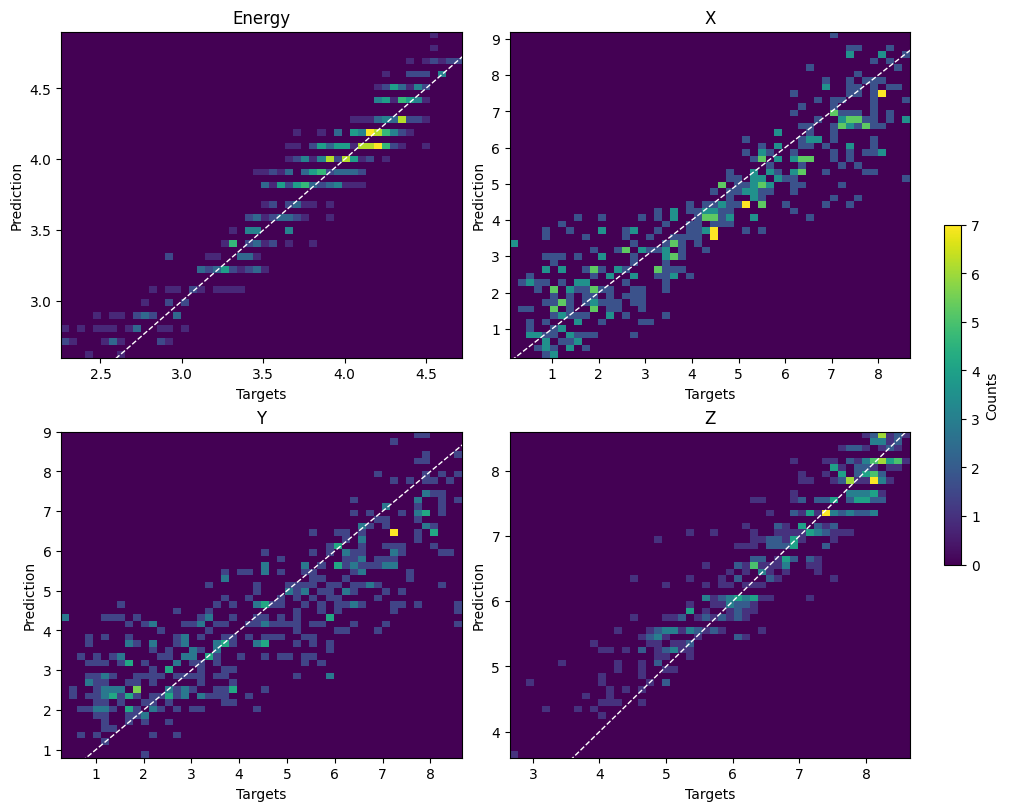

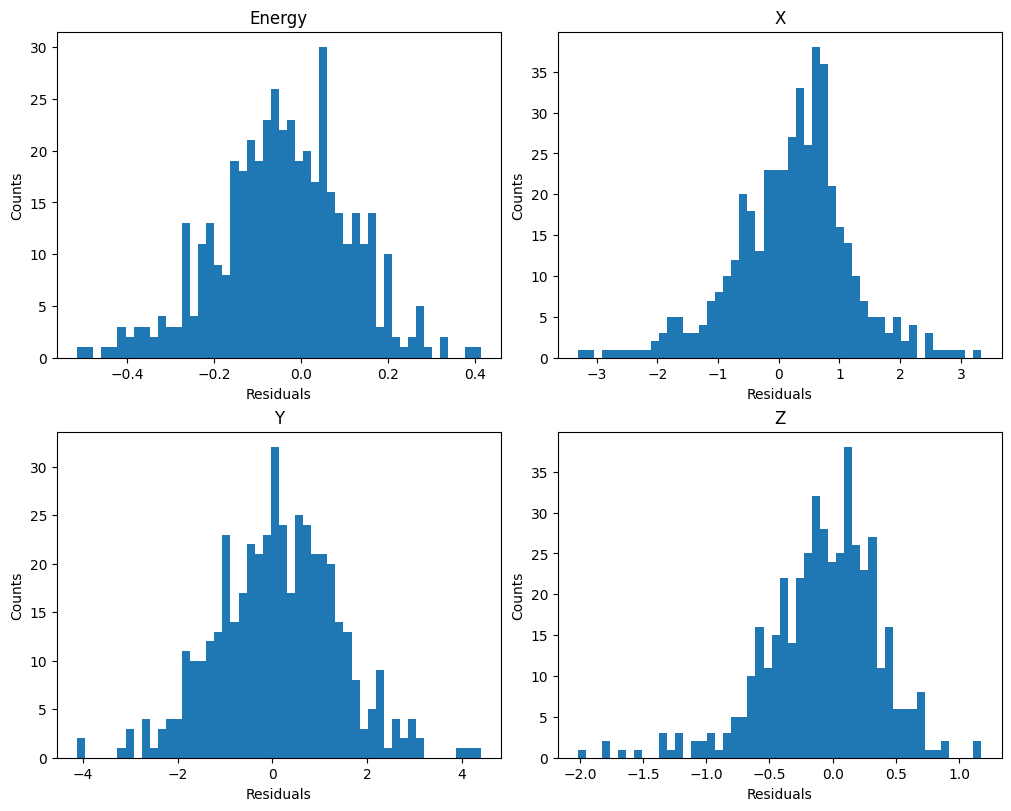

In [29]:
train_Epos_spk.predict.accuracy_fn = lambda p, t: absolute_distance(p, t, relative=True)
train_Epos_spk.test("test")
train_Epos_spk.predict.accuracy_fn = lambda p, t: distance(p, t, relative=False)
train_Epos_spk.show_results(nbins=50, title=["Energy", "X", "Y", "Z"])

torch.Size([2242, 4])


IndexError: string index out of range

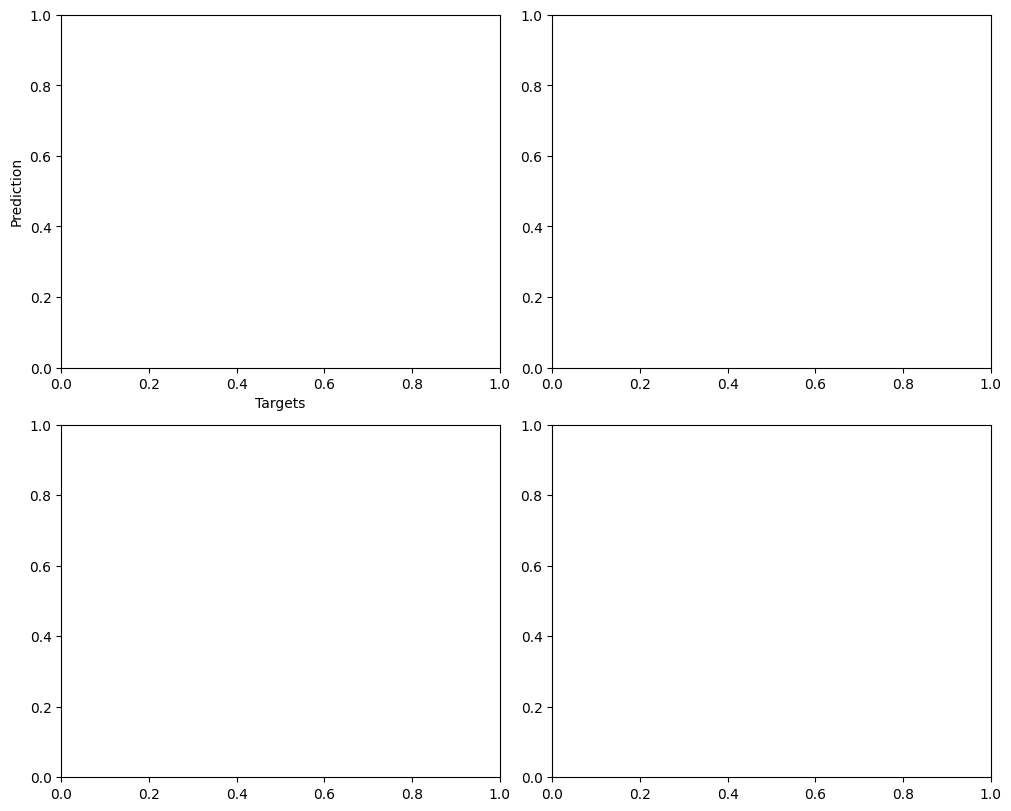

In [113]:
self = train_Epos_spk
transform = lambda a: a
targets, predictions, accuracy = self._get_all(transform=transform)
print(targets.shape)
self._plot_results(targets=targets, predictions=predictions, plot_type="2D") 
self._plot_results(accuracy=accuracy, plot_type="1D")

torch.Size([2242, 4])
torch.Size([2242, 4])
torch.Size([2242, 4]) torch.Size([2242, 4])
torch.Size([2242, 4]) torch.Size([2242, 4])
torch.Size([2242, 4]) torch.Size([2242, 4])
torch.Size([2242, 4]) torch.Size([2242, 4])


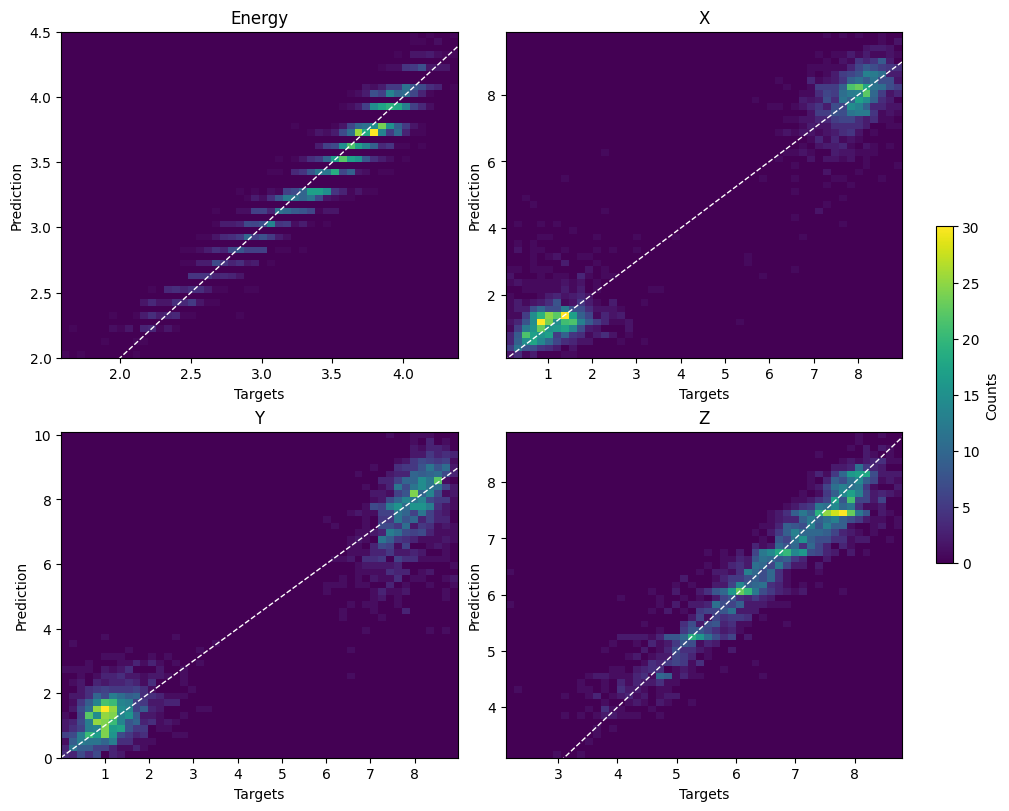

In [112]:
def test(self, targets = torch.tensor([]), predictions = torch.tensor([]),
                      accuracy = torch.tensor([]), plot_type : str = "2D",
                      nbins : int = 50, title : Union[str, list[str]] = "", logscale : bool = False, select : list = [],
                      *args, **kwargs):
        
        print(targets.shape)
        
        n_tasks = max(targets.shape[-1], accuracy.shape[-1])
        if select:
            n_tasks = min(n_tasks, len(select))
        else:
            select = [i for i in range(n_tasks)]
            
        ncols = math.ceil(math.sqrt(n_tasks))
        nrows = math.ceil(n_tasks / ncols)
        
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, facecolor="w", figsize=(5*ncols, 4*nrows),constrained_layout=True)
        if not isinstance(axs, np.ndarray):
            axs = np.array([axs])
            title = [title]
        axs = axs.flatten()

        for i in range(n_tasks):
            # plot 2D histogram of prediction vs targets
            if plot_type == "2D":
                axs[i].set_xlabel("Targets")
                axs[i].set_ylabel("Prediction")
                axs[i].set_title(title[i])
                print(targets.shape, predictions.shape)
                if logscale:
                    hist = axs[i].hist2d(targets[:, select[i]], predictions[:, select[i]],
                                         nbins, norm=SymLogNorm(*args, **kwargs), cmap='viridis')
                else:
                    hist = axs[i].hist2d(targets[:, select[i]], predictions[:, select[i]], nbins)
                axs[i].plot([0, 1e5], [0, 1e5], color='white', linewidth=1, linestyle='--')

            # plot 1D histogram of residuals
            if plot_type == "1D":
                axs[i].set_xlabel("Residuals")
                axs[i].set_ylabel("Counts")
                axs[i].set_title(title[i])
                hist = axs[i].hist(accuracy[:, select[i]], nbins)

        for i in range(n_tasks, len(axs)):
            fig.delaxes(axs[i])

        if plot_type == "2D":
            # Add a color bar
            if hist:
                cbar = fig.colorbar(hist[3], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
                cbar.set_label("Counts")  # Customize as needed


self = train_Epos_spk
transform = lambda a: a
#targets, predictions, accuracy = self._get_all(transform=transform)
print(targets.shape)
test(self, targets=targets, predictions=predictions, plot_type="2D", title=["Energy", "X", "Y", "Z"]) 

Test loss: 1.5707387076483832
Test relative error: [27.690458 35.232548 54.922096  5.008157]%


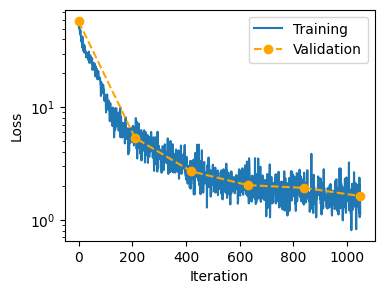

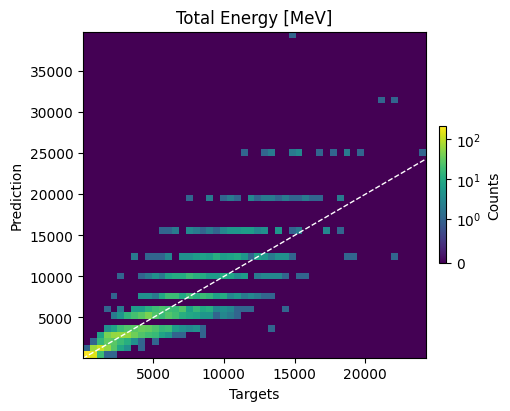

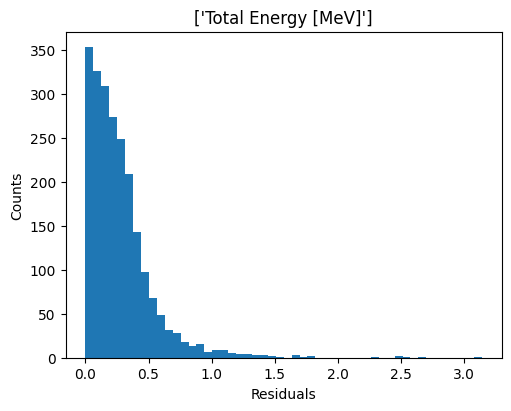

In [78]:
def antitransform(x):
    a = x.clone() 
    a[:, 0] = torch.pow(10, a[:,0])
    return a

train_Epos_spk.predict.accuracy_fn = lambda p, t: absolute_distance(p, t, relative=True, transform=antitransform)

train_Epos_spk.test("test")
train_Epos_spk.show_results(nbins=50, logscale=True, linthresh=1, title="Total Energy [MeV]",
                            select=[0], transform=antitransform)

Test loss: 1.40256507396698
Test relative error: [ 3.346506  39.387905  41.133972   4.5327325]%


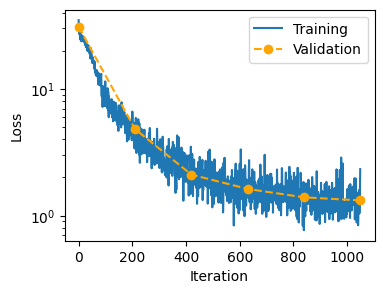

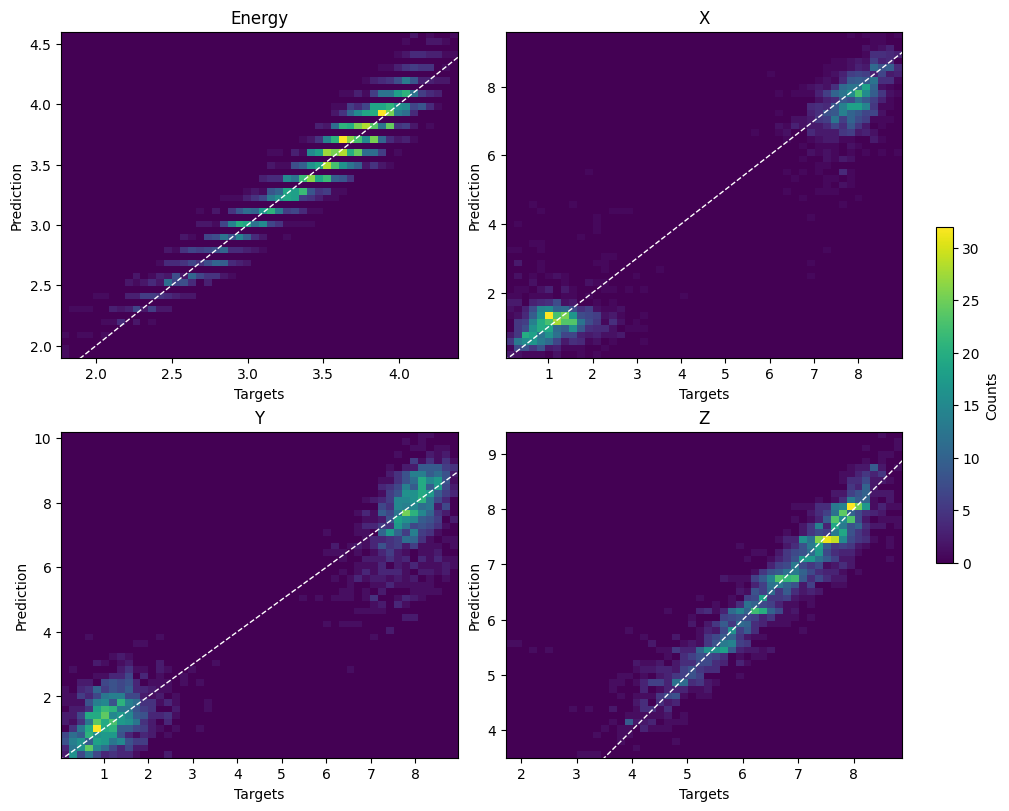

In [86]:
train_Epos_spk.test("test")
train_Epos_spk.show_results(nbins=50, title=["Energy", "X", "Y", "Z"])

In [87]:
train_Epos_spk.predict.relative = False
train_Epos_spk.test("test")
print(f"Test absolute error: {train_Epos_spk.acc_hist['test'][train_Epos_spk.current_epoch]}")

Test absolute error: [0.11302733 0.51188725 0.6283291  0.273713  ]


Test loss: 48450219.244444445
Test relative error: [28.049618  39.42041   40.996613   4.5246606]%


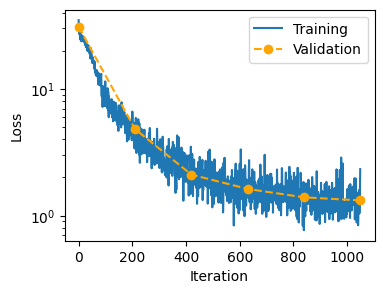

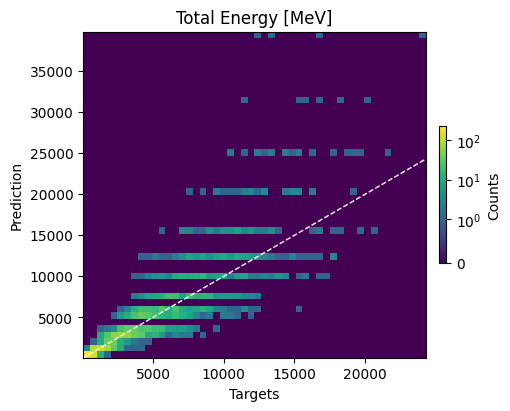

In [92]:
def antitransform(x):
    a = x.clone() 
    a[:, 0] = torch.pow(10, a[:,0])
    return a
train_Epos_spk.predict.transform = antitransform
train_Epos_spk.predict.relative = True

train_Epos_spk.test("test")
train_Epos_spk.show_results(nbins=50, logscale=True, linthresh=1, title="Total Energy [MeV]", select=[0])

In [93]:
train_Epos_spk.predict.relative = False
train_Epos_spk.test("test")
print(f"Test absolute error: {train_Epos_spk.acc_hist['test'][train_Epos_spk.current_epoch]}")

Test absolute error: [1.3464832e+03 5.1215780e-01 6.2855136e-01 2.7366880e-01]


# Particle Classification

In [9]:
data_train, data_test, data_val = ds.build_dataset("../Data", max_files=5, target="particle")

FileNotFoundError: [Errno 2] No such file or directory: '../Data/kaon/kaon_1.dat'

In [ ]:
batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
from collections import Counter
Counter([d[1] for d in data_train])

In [ ]:
#loss = nn.MSELoss()
num_inputs = 100
num_hidden = 200
num_outputs = nClasses
num_steps = timesteps
net = Net_LIF_1L(num_inputs, num_hidden, num_outputs, num_steps)

In [ ]:
def comp_accuracy(output, targets):
    _, predicted = output.sum(dim=0).max(1)
    total = targets.size(0)
    correct = (predicted == targets).sum().item()

    return predicted, correct/total

In [ ]:
loss_fn = SF.ce_count_loss(num_classes=nClasses)
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

train_net = Trainer(net, loss_fn, optimizer, train_load, val_load, test_load, comp_accuracy)

In [ ]:
num_epochs = 5
train_net.train(num_epochs)

In [ ]:
train_net.plot_loss()

In [ ]:
train_net.test("test", mc=True, num_classes=nClasses)
print(train_net.loss_hist["test"])
train_net.cm["test"].plot()

# Energy Regression

In [34]:
dataset.transform = lambda x: (x[0], ds.to_tensor_and_dtype(np.log10(x[1][0]), torch.float32))

#mask = [((d[0] != 0).any() and d[1] > 0).item()  and i < 10000  for i, d in enumerate(dataset)]
#dataset = dataset[mask]
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

Minimum energy: 1.0979242324829102


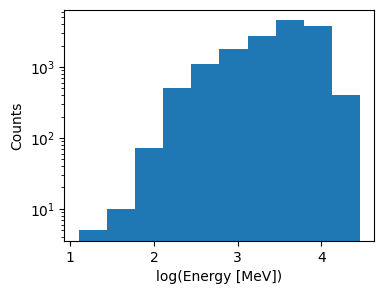

In [131]:
energies = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(4, 3))
plt.xlabel("log(Energy [MeV])")
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(energies)

print(f"Minimum energy: {min(energies)}")

### Membrane Potential

In [35]:
net_E_mem = Spiking_Net(net_desc_membrane, lambda x: spikegen_multi(x,4)) 
Pred = Predictor(predict_membrane)
loss_fn = nn.MSELoss() #multi_MSELoss(weights=torch.tensor([1]))
optimizer = torch.optim.Adam(net_E_mem.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net = Trainer(net_E_mem, loss_fn, optimizer, Pred,
                    train_dataset, val_dataset, test_dataset)

In [36]:
num_epochs = 5
train_net.train(num_epochs)

Epoch 0:
Validation Loss = 13.216610548231337
Validation Average Error = 1.0388578176498413

-------------------------------



Epoch:  20%|██        | 1/5 [00:28<01:55, 28.83s/it]

Epoch 1:
Validation Loss = 0.02019848929097255
Validation Average Error = 0.033499542623758316

-------------------------------



Epoch:  40%|████      | 2/5 [00:57<01:26, 29.00s/it]

Epoch 2:
Validation Loss = 0.017365276896291307
Validation Average Error = 0.031065484508872032

-------------------------------



Epoch:  60%|██████    | 3/5 [01:26<00:57, 28.63s/it]

Epoch 3:
Validation Loss = 0.01606104796131452
Validation Average Error = 0.029995817691087723

-------------------------------



Epoch:  80%|████████  | 4/5 [01:54<00:28, 28.65s/it]

Epoch 4:
Validation Loss = 0.01501736647138993
Validation Average Error = 0.0290078055113554

-------------------------------



Epoch: 100%|██████████| 5/5 [02:23<00:00, 28.76s/it]

Epoch 5:
Validation Loss = 0.013977037059764068
Validation Average Error = 0.027975257486104965

-------------------------------



Test loss: 0.01204594484426909
Test relative error: 2.580167531967163%


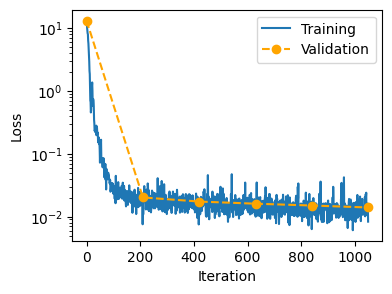

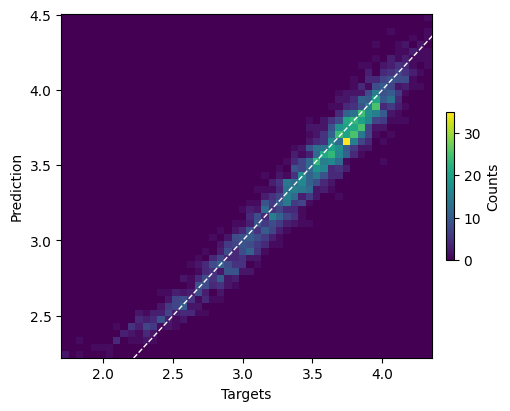

In [37]:
train_net.test("test")
train_net.show_results(nbins=50)

Test loss: 30511957.2
Test relative error: 19.373558044433594%


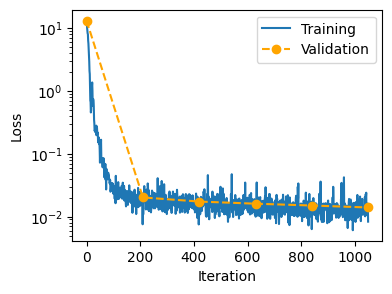

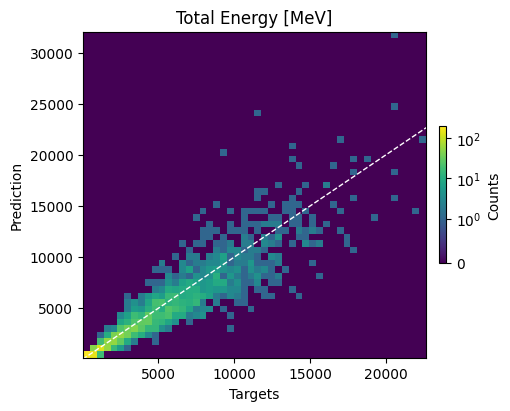

In [44]:
def antitransform(x):
    return torch.pow(10, x)
train_net.predict.transform = antitransform

train_net.test("test")
train_net.show_results(nbins=50, logscale=True, linthresh=1, title="Total Energy [MeV]")

Test loss: 0.0134462701363696
Test relative error: 2.687971353530884%


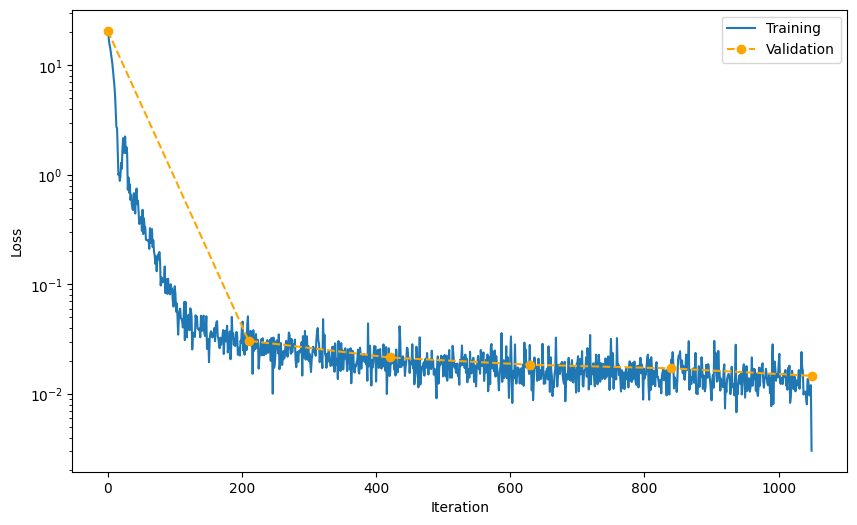

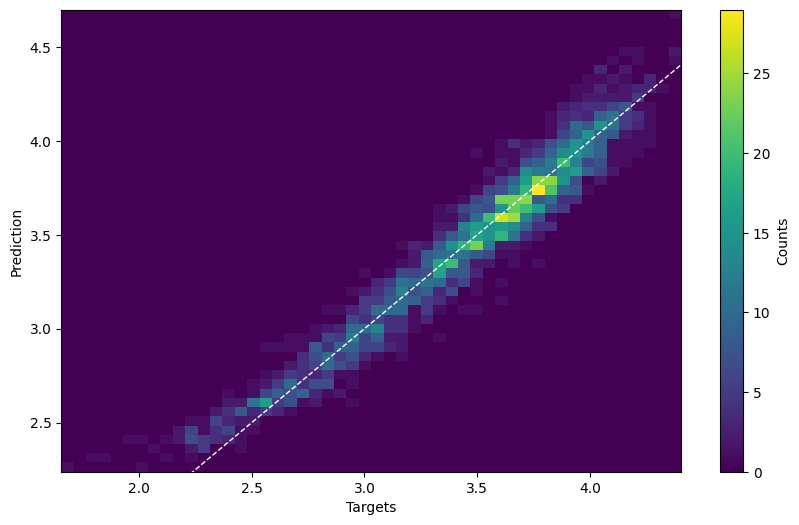

In [44]:
train_net.test("test")
print(f"Test loss: {train_net.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net.acc_hist['test'][num_epochs]*100}%")
train_net.plot_loss()
train_net.plot_pred_vs_target(50, logscale=False, linthresh=1)

Test loss: 0.013442321421785487
Test relative error: 21.649005889892578%


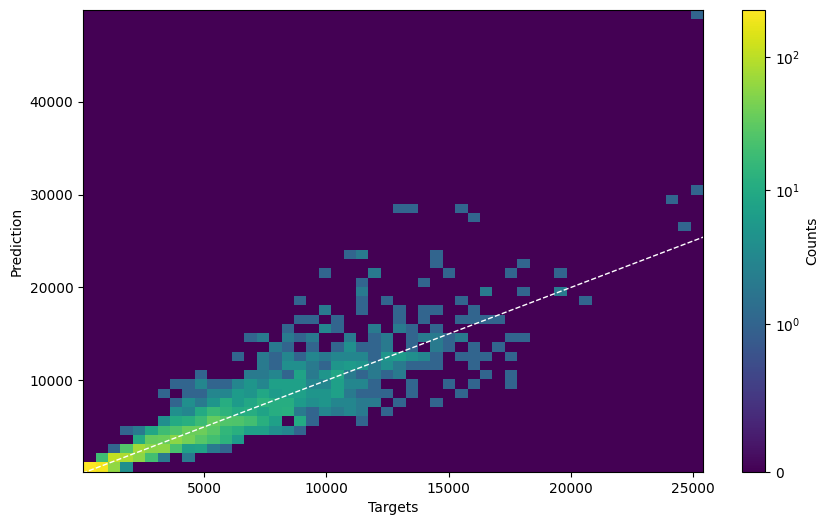

In [45]:
def antitransform(x):
    return torch.pow(10, x)

train_net.test("test", transform=antitransform)
print(f"Test loss: {train_net.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net.acc_hist['test'][num_epochs]*100}%")
train_net.plot_pred_vs_target(50, transform=antitransform, logscale=True, linthresh=1)

### SpikeFreq

In [45]:
net_E_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4)) 
Pred_E_spk = Predictor(predict_spikefreq)
loss_fn = nn.MSELoss() #multi_MSELoss(weights=torch.tensor([1]))
opt_E_spk = torch.optim.Adam(net_E_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_E_spk = Trainer(net_E_spk, loss_fn, opt_E_spk, Pred_E_spk,
                      train_dataset, val_dataset, test_dataset)

In [47]:
num_epochs = 5
train_E_spk.train(num_epochs)

Epoch 0:
Validation Loss = 1.3845133993360732
Validation Average Error = 0.295183002948761

-------------------------------



Epoch:  20%|██        | 1/5 [00:34<02:19, 34.79s/it]

Epoch 1:
Validation Loss = 0.016436778008937836
Validation Average Error = 0.03030942566692829

-------------------------------



Epoch:  40%|████      | 2/5 [01:11<01:47, 35.79s/it]

Epoch 2:
Validation Loss = 0.011699614973945751
Validation Average Error = 0.025289010256528854

-------------------------------



Epoch:  60%|██████    | 3/5 [01:46<01:10, 35.34s/it]

Epoch 3:
Validation Loss = 0.010220556913150682
Validation Average Error = 0.02362404577434063

-------------------------------



Epoch:  80%|████████  | 4/5 [02:18<00:34, 34.19s/it]

Epoch 4:
Validation Loss = 0.01059014450551735
Validation Average Error = 0.02442145347595215

-------------------------------



Epoch: 100%|██████████| 5/5 [02:50<00:00, 34.13s/it]

Epoch 5:
Validation Loss = 0.010133363140953911
Validation Average Error = 0.02355721779167652

-------------------------------



Test loss: 0.008932197435448567
Test relative error: 2.1948955059051514%


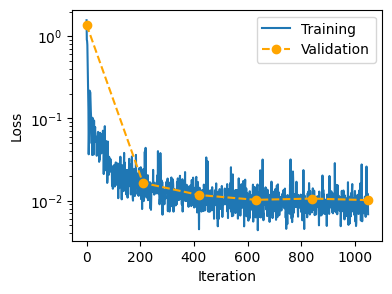

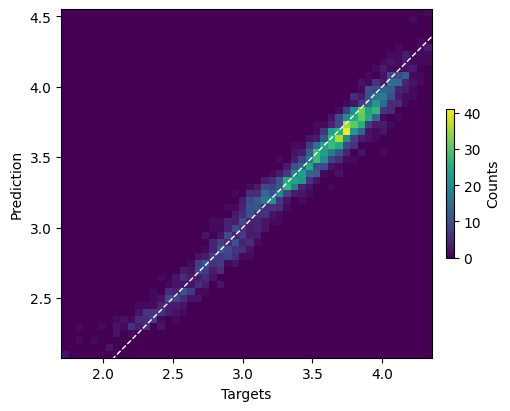

In [48]:
train_E_spk.test("test")
train_E_spk.show_results(nbins=50)

Test loss: 27758772.31111111
Test relative error: 16.318721771240234%


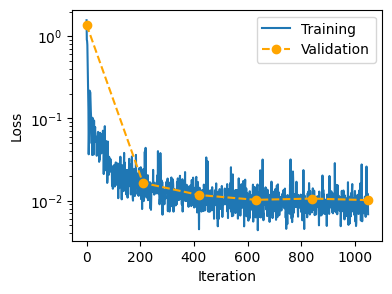

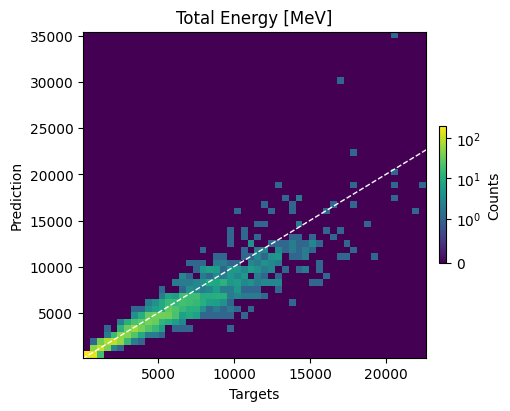

In [49]:
def antitransform(x):
    return torch.pow(10, x)
train_E_spk.predict.transform = antitransform

train_E_spk.test("test")
train_E_spk.show_results(nbins=50, logscale=True, linthresh=1, title="Total Energy [MeV]")

In [71]:
net_E_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
opt_E_spk = torch.optim.Adam(net_E_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_E_spk = Trainer(net_E_spk, loss_fn, opt_E_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

Epoch 0:
Validation Loss = 0.6981234735912747
Validation Accuracy = 0.20573092997074127

-------------------------------



Epoch:  20%|██        | 1/5 [00:31<02:06, 31.61s/it]

Epoch 1:
Validation Loss = 0.01650969928337468
Validation Accuracy = 0.030073730275034904

-------------------------------



Epoch:  40%|████      | 2/5 [01:03<01:34, 31.61s/it]

Epoch 2:
Validation Loss = 0.010779590666708019
Validation Accuracy = 0.024441005662083626

-------------------------------



Epoch:  60%|██████    | 3/5 [01:34<01:03, 31.58s/it]

Epoch 3:
Validation Loss = 0.010907768696132634
Validation Accuracy = 0.02463482692837715

-------------------------------



Epoch:  80%|████████  | 4/5 [02:06<00:31, 31.58s/it]

Epoch 4:
Validation Loss = 0.009967082966532972
Validation Accuracy = 0.023397140204906464

-------------------------------



Epoch: 100%|██████████| 5/5 [02:36<00:00, 31.36s/it]

Epoch 5:
Validation Loss = 0.009872432415270143
Validation Accuracy = 0.023157639428973198

-------------------------------



Test loss: 0.010411505380438434
Test relative error: 2.3691983222961426%


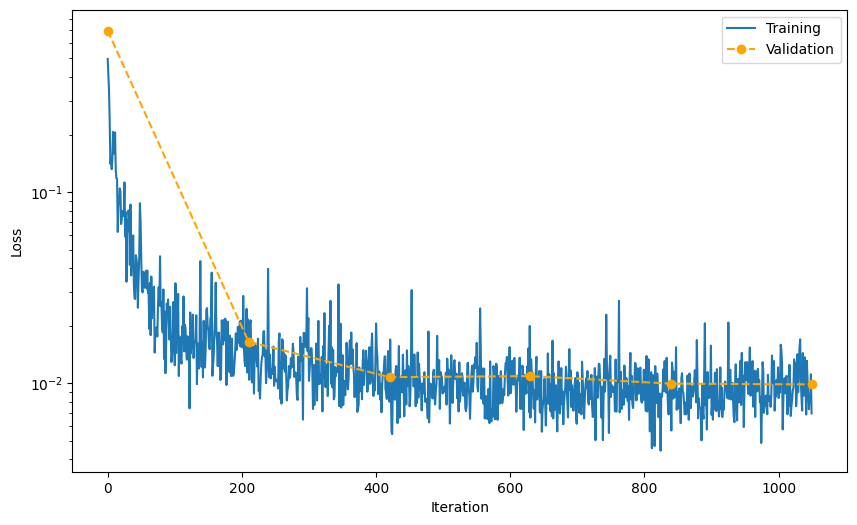

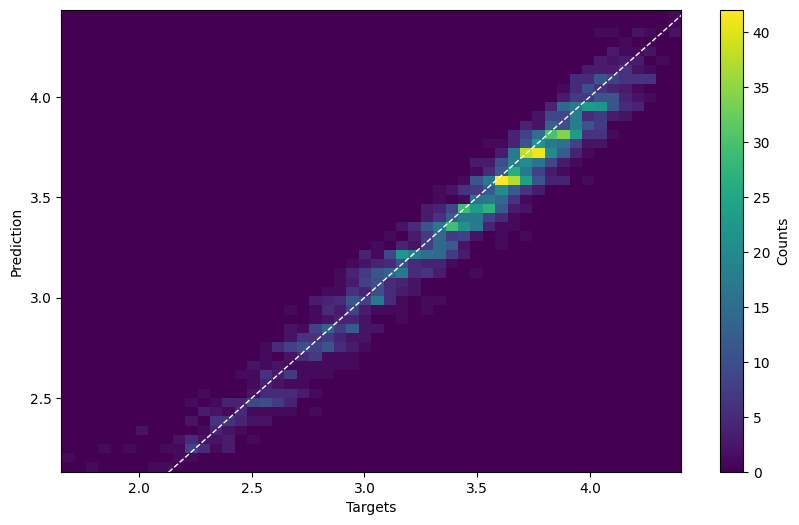

In [72]:
num_epochs=5
train_E_spk.train(num_epochs)

train_E_spk.test("test")
print(f"Test loss: {train_E_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_E_spk.acc_hist['test'][num_epochs]*100}%")
train_E_spk.plot_loss()
train_E_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

Test loss: 0.010402999125007126
Test relative error: 17.370105743408203%


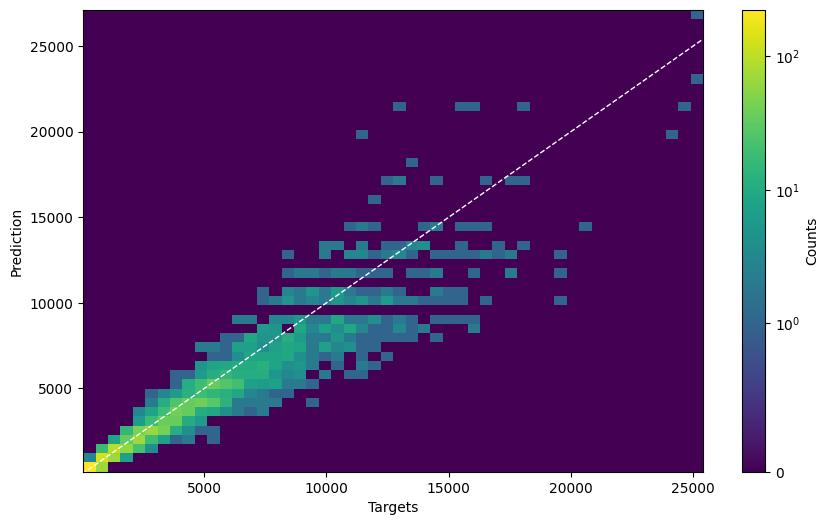

In [74]:
def antitransform(x):
    return torch.pow(10, x)

train_E_spk.test("test", transform=antitransform)
print(f"Test loss: {train_E_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_E_spk.acc_hist['test'][num_epochs]*100}%")
train_E_spk.plot_pred_vs_target(50, transform=antitransform, logscale=True, linthresh=1)

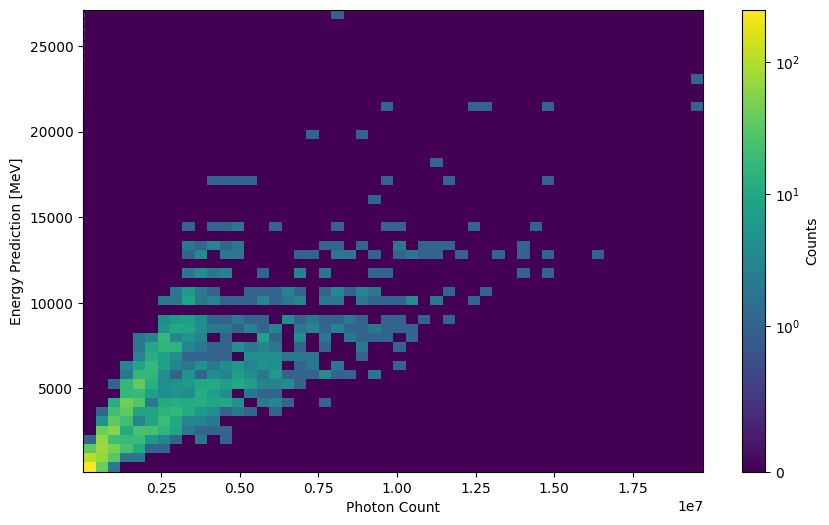

In [76]:
net.eval()
all_x = []
all_predictions = []
with torch.no_grad():
    for data, targets in test_dataset:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        output = net_E_spk(data)
        # calculate total accuracy
        pred, acc = predict_spikefreq(output, targets, antitransform)
        all_predictions.extend(pred.tolist())
        all_x.extend(data.sum((1,2)).tolist())
        
fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel("Photon Count")
plt.ylabel("Energy Prediction [MeV]")
plt.hist2d(all_x, all_predictions, 50, norm=SymLogNorm(linthresh=1), cmap='viridis')
# Add a color bar
plt.colorbar(label='Counts')
plt.plot([0, 1e5], [0, 1e5], color='white', linewidth=1, linestyle='--')

### Linear Model

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly2", max_files=5, primary_only=True,
                                                   target=["energy", "centroid"])

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/All", max_files=100, primary_only=False,
                                                   target=["energy", "centroid"])

In [ ]:
lin_model     = LinearRegression()
lin_model_log = LinearRegression()

x, y = zip(*[data_train[i] for i in range(len(data_train))])
E = np.array([y[0] for y in y])
centroid = np.array([y[1] for y in y])
#primary = np.array([y[2] for y in y])

# Convert to NumPy arrays
x = torch.stack(x).sum((1,2)).numpy()  # Convert features to NumPy

# eliminate results with no photons
mask = x > 0
x = x[mask]
E = E[mask]
centroid = centroid[mask]
#primary = primary[mask]

# convert to double log scale
x_log = np.log10(x)
E_log = np.log10(E)

lin_model.fit(x.reshape(-1,1), E)
lin_model_log.fit(x_log.reshape(-1,1), E_log)
print("Linear Model:")
print("Slope:", lin_model.coef_[0])
print("Intercept:", lin_model.intercept_)
print("\n###################\n\nLinear Model Trained on logs:")
print("Slope:", lin_model_log.coef_[0])
print("Intercept:", lin_model_log.intercept_)

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel("log(Energy [MeV])")
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(E_log)

In [ ]:
x_test, y_test = zip(*[data_train[i] for i in range(len(data_test))])
E_test = np.array([y[0] for y in y_test])
centroid_test = np.array([y[1] for y in y_test])
#primary_test = np.array([y[2] for y in y_test])

# Convert to NumPy arrays
x_test = torch.stack(x_test).sum((1,2)).numpy()  # Convert features to NumPy

# eliminate results with no photons
mask = x_test > 0
x_test = x_test[mask]
E_test = E_test[mask]
centroid_test = centroid_test[mask]
#primary_test = primary_test[mask]

x_test_log = np.log10(x_test)
E_test_log = np.log10(E_test)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

x_plot = np.arange(0.1, np.max(x_test), 1e3)
y_plot = lin_model.predict(x_plot.reshape(-1,1))
x_plot_log = np.arange(0.1, np.max(x_test_log), 0.1)
y_plot_log = lin_model_log.predict(x_plot_log.reshape(-1,1))

ax[0].set_xlabel("log(Photon Count)")
ax[0].set_ylabel("log(Energy [MeV])")
hb0 = ax[0].hist2d(x_test_log, E_test_log, 50, norm=SymLogNorm(linthresh=1), cmap='viridis')
ax[0].plot(np.log10(x_plot), np.log10(y_plot), color='white',
           linewidth=2, linestyle='--', label="Linear Model Prediction")
ax[0].plot(x_plot_log, y_plot_log, color='#FF00FF',
           linewidth=2, linestyle='--', label="Log Model Prediction")
cbar0 = fig.colorbar(hb0[3], ax=ax[0])
cbar0.set_label('Data')  # Label for the first colorbar
ax[0].legend()

ax[1].set_xlabel("Photon Count")
ax[1].set_ylabel("Energy [MeV]")
hb1 = ax[1].hist2d(x_test, E_test, 50, norm=SymLogNorm(linthresh=1), cmap='viridis')
ax[1].plot(x_plot, y_plot, color='white',
           linewidth=1, linestyle='--', label="Linear Model Prediction")
ax[1].plot(np.pow(10,x_plot_log), np.pow(10,y_plot_log), color='#FF00FF',
           linewidth=1, linestyle='--', label="Log Model Prediction")
cbar1 = fig.colorbar(hb1[3], ax=ax[1])
cbar1.set_label('Data')  # Label for the first colorbar
ax[1].legend()

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

condition = centroid_test[:,1] < 5

ax[0].set_title("Y idx < 5")
ax[0].set_ylabel("Energy [MeV]")
hb0 = ax[0].hist2d(x_test[condition], E_test[condition], 50, norm=SymLogNorm(linthresh=1, vmax=1e4, vmin=0), cmap='viridis')
ax[0].plot(x_plot, y_plot, color='white',
           linewidth=1, linestyle='--', label="Linear Model Prediction")
ax[0].plot(np.pow(10,x_plot_log), np.pow(10,y_plot_log), color='#FF00FF',
           linewidth=1, linestyle='--', label="Log Model Prediction")
ax[0].legend()


condition = centroid_test[:,1] >= 5

ax[1].set_title("Y idx >= 5")
hb1 = ax[1].hist2d(x_test[condition], E_test[condition], 50, norm=SymLogNorm(linthresh=1, vmax=1e4, vmin=0), cmap='viridis')
ax[1].plot(x_plot, y_plot, color='white',
           linewidth=1, linestyle='--', label="Linear Model Prediction")
ax[1].plot(np.pow(10,x_plot_log), np.pow(10,y_plot_log), color='#FF00FF',
           linewidth=1, linestyle='--', label="Log Model Prediction")
ax[1].legend()

cbar1 = fig.colorbar(hb1[3], ax=ax)
cbar1.set_label('Data') 
fig.text(0.5, 0.04, 'Photon Count', ha='center')
#plt.tight_layout(rect=[0.05, 0.05, 1, 1])

In [ ]:
E_pred = lin_model.predict(x_test.reshape(-1,1))
acc = np.mean(abs((E_test-E_pred)/E_test)*100)
print(f"Mean relative error: {acc}%")

In [ ]:
E_pred_log = lin_model_log.predict(x_test_log.reshape(-1,1))
acc = np.mean(abs((np.pow(10,E_test_log)-np.pow(10,E_pred_log))/np.pow(10,E_test_log))*100)
print(f"Mean relative error: {acc}%")

In [ ]:
mask_up   = E_test_log > lin_model_log.predict(x_test_log.reshape(-1,1))
mask_down = E_test_log < lin_model_log.predict(x_test_log.reshape(-1,1))

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(8,6))
ax.hist(centroid_test[mask_up, 1], bins=[-0.5+i for i in range(11)], 
        edgecolor='blue', facecolor='white', linewidth=1.5, label='E > prediction', alpha=0.8)
ax.hist(centroid_test[mask_down, 1], bins=[-0.5+i for i in range(11)], 
        edgecolor='orange', facecolor='white', linewidth=1.5, label='E < prediction', alpha=0.8)
ax.hist(centroid_test[:, 1], bins=[-0.5+i for i in range(11)], 
        edgecolor='grey', facecolor='lightgrey', alpha=0.2, linewidth=1.5, label='Global')
ax.set_xticks([i for i in range(10)])
ax.legend()
ax.set_xlabel("Centroid Y cell")
ax.set_ylabel("Counts per cell")

# Energy Centroid

## X

In [14]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][1][0]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

(array([2.785e+03, 4.218e+03, 7.380e+02, 6.000e+01, 3.000e+00, 7.000e+00,
        6.300e+01, 7.170e+02, 3.852e+03, 2.499e+03]),
 array([1.89307181e-03, 9.01477814e-01, 1.80106258e+00, 2.70064735e+00,
        3.60023212e+00, 4.49981689e+00, 5.39940166e+00, 6.29898643e+00,
        7.19857121e+00, 8.09815598e+00, 8.99774075e+00]),
 <BarContainer object of 10 artists>)

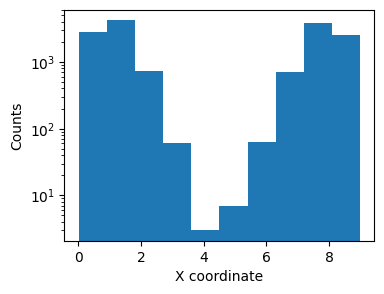

In [15]:
X = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(4, 3))
plt.xlabel("X coordinate")
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(X)

In [17]:
net_x_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
opt_x_spk = torch.optim.Adam(net_x_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_x_spk = Trainer(net_x_spk, loss_fn, opt_x_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

Epoch 0:
Validation Loss = 11.651428900824653
Validation Accuracy = 2.6451773643493652

-------------------------------



Epoch:  20%|██        | 1/5 [00:33<02:13, 33.33s/it]

Epoch 1:
Validation Loss = 1.662094349331326
Validation Accuracy = 0.6654527187347412

-------------------------------



Epoch:  40%|████      | 2/5 [01:11<01:47, 35.91s/it]

Epoch 2:
Validation Loss = 0.9150732311937544
Validation Accuracy = 0.5254722237586975

-------------------------------



Epoch:  60%|██████    | 3/5 [01:47<01:12, 36.23s/it]

Epoch 3:
Validation Loss = 0.751846127377616
Validation Accuracy = 0.4876992106437683

-------------------------------



Epoch:  80%|████████  | 4/5 [02:17<00:33, 33.88s/it]

Epoch 4:
Validation Loss = 0.48519932130972543
Validation Accuracy = 0.3561718761920929

-------------------------------



Epoch: 100%|██████████| 5/5 [02:48<00:00, 33.67s/it]

Epoch 5:
Validation Loss = 0.43042967783080205
Validation Accuracy = 0.3300425708293915

-------------------------------



Test loss: 0.4410140835576587
Test relative error: 77.81681060791016%


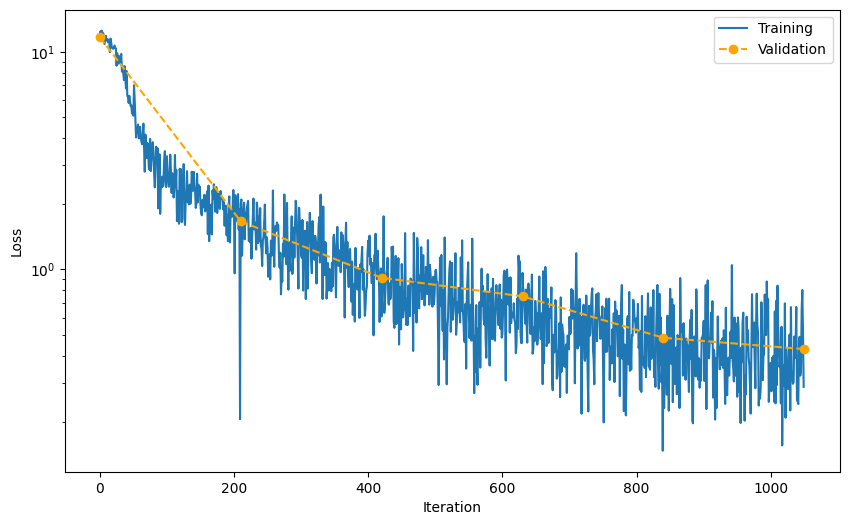

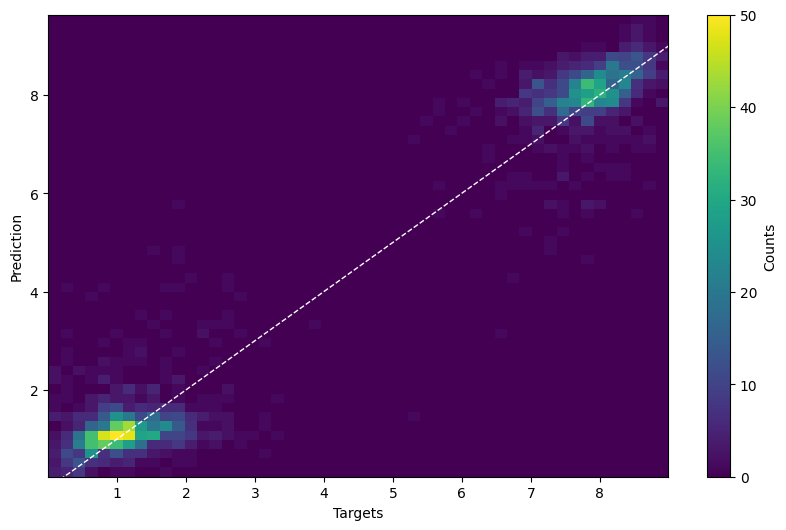

In [18]:
num_epochs=5
train_x_spk.train(num_epochs)

train_x_spk.test("test")
print(f"Test loss: {train_x_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_x_spk.acc_hist['test'][num_epochs]*100}%")
train_x_spk.plot_loss()
train_x_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

## Z

In [19]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][1][2]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

(array([4.000e+00, 8.000e+00, 3.500e+01, 2.610e+02, 1.295e+03, 2.862e+03,
        3.635e+03, 5.238e+03, 1.604e+03]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

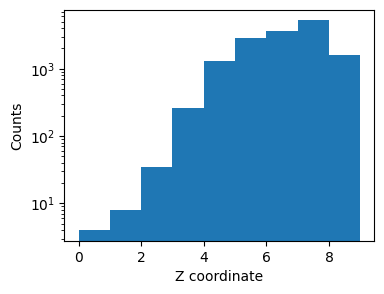

In [23]:
Z = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(4, 3))
plt.xlabel("Z coordinate")
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(Z, bins=[i for i in range(10)])

In [24]:
net_z_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
opt_z_spk = torch.optim.Adam(net_z_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_z_spk = Trainer(net_z_spk, loss_fn, opt_z_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

Epoch 0:
Validation Loss = 16.077254019843206
Validation Accuracy = 0.5613648295402527

-------------------------------



Epoch:  20%|██        | 1/5 [00:37<02:31, 37.86s/it]

Epoch 1:
Validation Loss = 0.3304861542251375
Validation Accuracy = 0.07528409361839294

-------------------------------



Epoch:  40%|████      | 2/5 [01:15<01:53, 37.74s/it]

Epoch 2:
Validation Loss = 0.21137214369244045
Validation Accuracy = 0.05694345012307167

-------------------------------



Epoch:  60%|██████    | 3/5 [01:49<01:12, 36.11s/it]

Epoch 3:
Validation Loss = 0.19862005793386037
Validation Accuracy = 0.05498804524540901

-------------------------------



Epoch:  80%|████████  | 4/5 [02:19<00:33, 33.75s/it]

Epoch 4:
Validation Loss = 0.18622308837042914
Validation Accuracy = 0.05318153277039528

-------------------------------



Epoch: 100%|██████████| 5/5 [02:50<00:00, 34.06s/it]

Epoch 5:
Validation Loss = 0.15027975870503318
Validation Accuracy = 0.047176264226436615

-------------------------------



Test loss: 0.11744212259848913
Test relative error: 3.956234931945801%


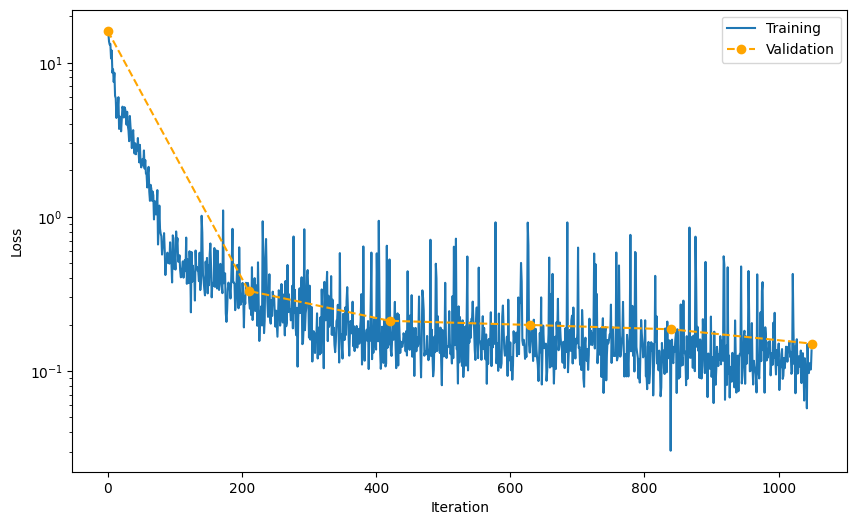

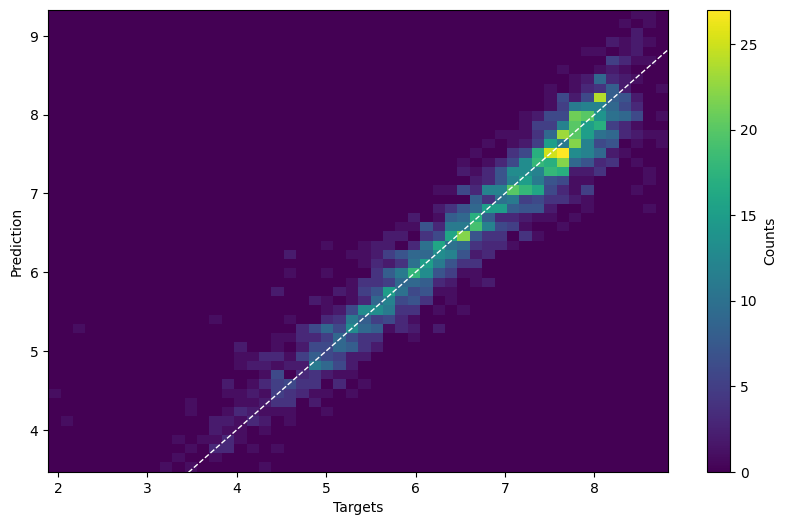

In [25]:
num_epochs=5
train_z_spk.train(num_epochs)

train_z_spk.test("test")
print(f"Test loss: {train_z_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_z_spk.acc_hist['test'][num_epochs]*100}%")
train_z_spk.plot_loss()
train_z_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

## Y

In [26]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][1][1]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

(array([3322., 3992.,  456.,   26.,    4.,   35.,  404., 3562., 3141.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

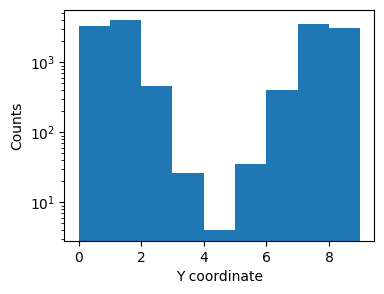

In [27]:
Y = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(4, 3))
plt.xlabel("Y coordinate")
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(Y, bins=[i for i in range(10)])

In [28]:
net_y_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
opt_y_spk = torch.optim.Adam(net_y_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_y_spk = Trainer(net_y_spk, loss_fn, opt_y_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

Epoch 0:
Validation Loss = 13.897302712334527
Validation Accuracy = 1.616141438484192

-------------------------------



Epoch:  20%|██        | 1/5 [00:30<02:03, 30.98s/it]

Epoch 1:
Validation Loss = 2.9834296809302434
Validation Accuracy = 1.1653534173965454

-------------------------------



Epoch:  40%|████      | 2/5 [01:00<01:30, 30.26s/it]

Epoch 2:
Validation Loss = 1.5282409601741367
Validation Accuracy = 0.8241036534309387

-------------------------------



Epoch:  60%|██████    | 3/5 [01:29<00:59, 29.65s/it]

Epoch 3:
Validation Loss = 1.0891364256540934
Validation Accuracy = 0.6484144330024719

-------------------------------



Epoch:  80%|████████  | 4/5 [01:59<00:29, 29.53s/it]

Epoch 4:
Validation Loss = 0.8479975011613634
Validation Accuracy = 0.4993327558040619

-------------------------------



Epoch: 100%|██████████| 5/5 [02:29<00:00, 29.83s/it]

Epoch 5:
Validation Loss = 0.7902826382054223
Validation Accuracy = 0.5338393449783325

-------------------------------



Test loss: 0.7664727826913198
Test relative error: 55.15174865722656%


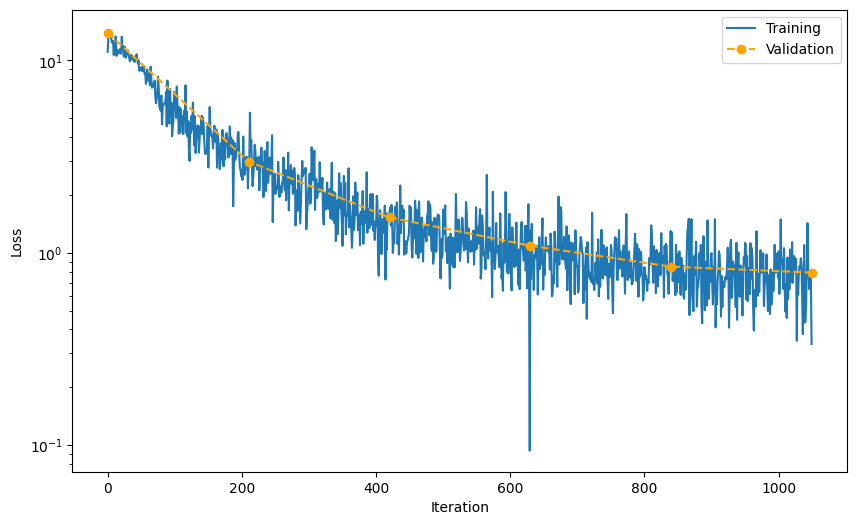

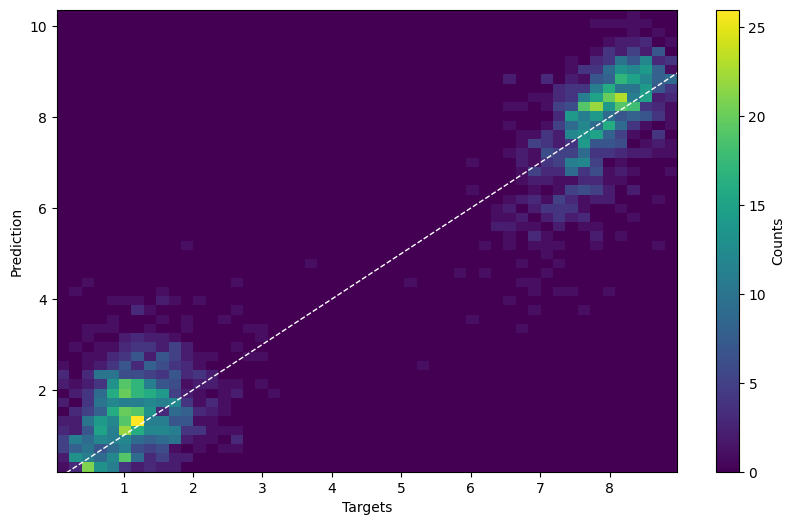

In [29]:
num_epochs=5
train_y_spk.train(num_epochs)

train_y_spk.test("test")
print(f"Test loss: {train_y_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_y_spk.acc_hist['test'][num_epochs]*100}%")
train_y_spk.plot_loss()
train_y_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

## X, Y and Z together

In [11]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][1]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [ ]:
set_seed(12)
a = torch.rand(size=(100,5,30))
b = torch.rand(size=(5,3))
p, a = predict_spikefreq_multitask(a, b)
print(p.shape, a.shape)
t = torch.rand(size=(5,3))
print(t)
print(p)
loss_fn = nn.MSELoss(reduction='sum')
o = loss_fn(t, p)
print(o)

In [ ]:
population = 10
net_centroid = {
    "layers" : [400, 200, 3*population],
    "timesteps": 100,
    "output": "membrane",
    "neuron_params" : {
                1: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True,
                    "spike_grad": surrogate.fast_sigmoid(),
                    }],
                2: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True, 
                    "spike_grad": surrogate.fast_sigmoid(),
                    }]
                }
    }

def predict_spikefreq_multitask(output, targets, transform=None):
    population=10
    output = output.reshape(output.shape[0], output.shape[1], population, -1)
    prediction = output.sum((0,2))/(output.shape[0]*output.shape[2])
    if transform:
        prediction, targets = transform(prediction), transform(targets)
    accuracy = torch.abs((targets - prediction)/targets)
    return prediction, torch.mean(accuracy, 0)

net_c = Spiking_Net(net_centroid, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
optimizer_c = torch.optim.Adam(net_c.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net_c = Trainer(net_c, loss_fn, optimizer_c, train_load, val_load, test_load, predict_spikefreq_multitask)

In [ ]:
train_net_c.train(5)

In [ ]:
train_net_c.acc_hist["validation"]

# Energy Dispersion

## X

In [30]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][2][0]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

(array([2.079e+03, 6.875e+03, 4.437e+03, 1.215e+03, 2.640e+02, 6.000e+01,
        8.000e+00, 1.000e+00, 2.000e+00, 1.000e+00]),
 array([2.25387281e-03, 1.79868197e+00, 3.59510994e+00, 5.39153814e+00,
        7.18796635e+00, 8.98439407e+00, 1.07808218e+01, 1.25772505e+01,
        1.43736782e+01, 1.61701069e+01, 1.79665356e+01]),
 <BarContainer object of 10 artists>)

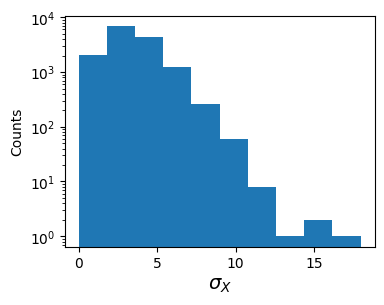

In [31]:
sigmaX = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(4, 3))
plt.xlabel(r'$\sigma_{X}$', fontsize=14)
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(sigmaX)

#print(f"Minimum energy: {min(energies)}")

In [33]:
net_sX_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

opt_sX_spk = torch.optim.Adam(net_sX_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_sX_spk = Trainer(net_sX_spk, loss_fn, opt_sX_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

Epoch 0:
Validation Loss = 2.841851398679945
Validation Accuracy = 1.4282584190368652

-------------------------------



Epoch:  20%|██        | 1/5 [00:30<02:02, 30.54s/it]

Epoch 1:
Validation Loss = 2.150192772017585
Validation Accuracy = 0.9743139743804932

-------------------------------



Epoch:  40%|████      | 2/5 [01:02<01:34, 31.37s/it]

Epoch 2:
Validation Loss = 1.9880393703778585
Validation Accuracy = 0.8556691408157349

-------------------------------



Epoch:  60%|██████    | 3/5 [01:33<01:02, 31.27s/it]

Epoch 3:
Validation Loss = 1.8848286628723145
Validation Accuracy = 0.7878502607345581

-------------------------------



Epoch:  80%|████████  | 4/5 [02:05<00:31, 31.45s/it]

Epoch 4:
Validation Loss = 1.8046665403578017
Validation Accuracy = 0.7295811176300049

-------------------------------



Epoch: 100%|██████████| 5/5 [02:37<00:00, 31.49s/it]

Epoch 5:
Validation Loss = 1.6063773128721448
Validation Accuracy = 0.7654386758804321

-------------------------------



Test loss: 1.571083018514845
Test relative error: 37.433250427246094%


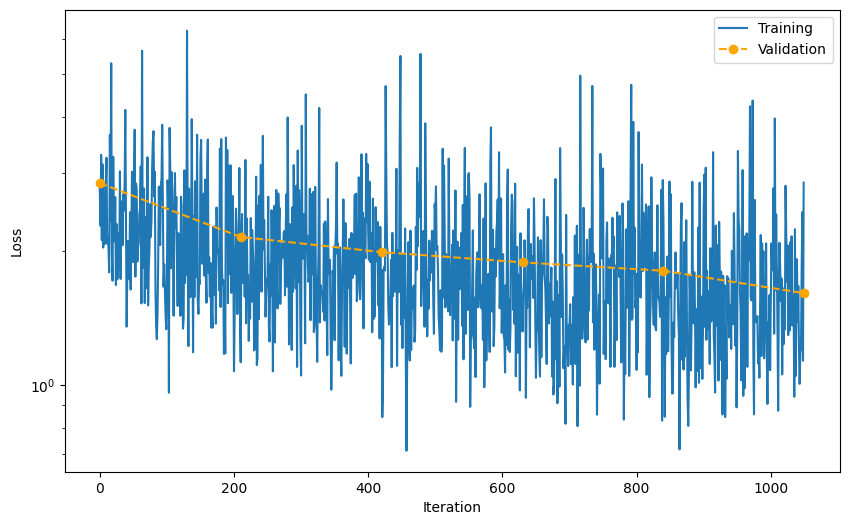

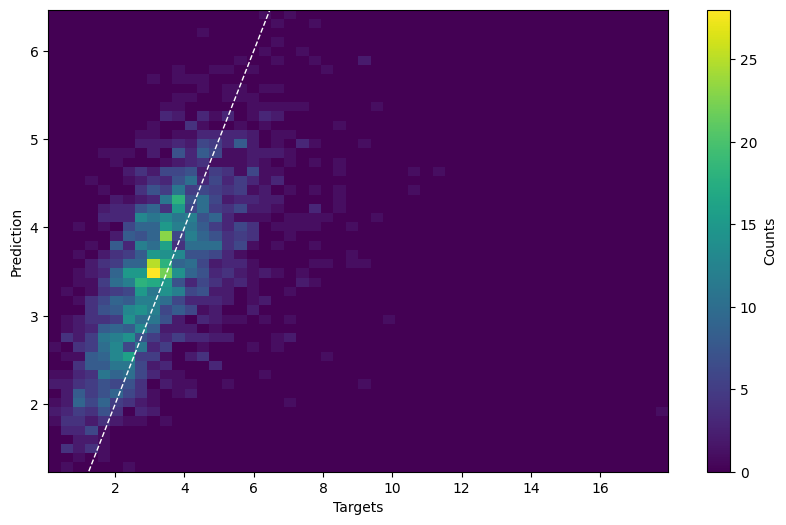

In [34]:
num_epochs=5
train_sX_spk.train(num_epochs)

train_sX_spk.test("test")
print(f"Test loss: {train_sX_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_sX_spk.acc_hist['test'][num_epochs]*100}%")
train_sX_spk.plot_loss()
train_sX_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

## Z

In [35]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][2][2]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

(array([9.200e+02, 5.246e+03, 4.617e+03, 2.656e+03, 9.160e+02, 3.700e+02,
        1.640e+02, 3.100e+01, 1.800e+01, 4.000e+00]),
 array([8.53405055e-03, 1.58943689e+00, 3.17033958e+00, 4.75124216e+00,
        6.33214521e+00, 7.91304827e+00, 9.49395084e+00, 1.10748539e+01,
        1.26557570e+01, 1.42366600e+01, 1.58175621e+01]),
 <BarContainer object of 10 artists>)

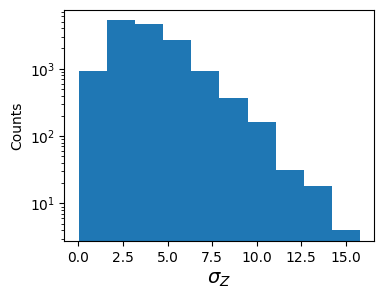

In [ ]:
sigmaZ = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(4, 3))
plt.xlabel(r'$\sigma_{Z}$', fontsize=14)
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(sigmaZ)

In [37]:
net_sZ_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

opt_sZ_spk = torch.optim.Adam(net_sZ_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_sZ_spk = Trainer(net_sZ_spk, loss_fn, opt_sZ_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

Epoch 0:
Validation Loss = 4.476911306381226
Validation Accuracy = 0.4376263916492462

-------------------------------



Epoch:  20%|██        | 1/5 [00:33<02:14, 33.55s/it]

Epoch 1:
Validation Loss = 1.1962298618422613
Validation Accuracy = 0.2569838762283325

-------------------------------



Epoch:  40%|████      | 2/5 [01:15<01:56, 38.70s/it]

Epoch 2:
Validation Loss = 0.8763659497102102
Validation Accuracy = 0.20249462127685547

-------------------------------



Epoch:  60%|██████    | 3/5 [01:51<01:14, 37.09s/it]

Epoch 3:
Validation Loss = 0.7602128426233927
Validation Accuracy = 0.1826673299074173

-------------------------------



Epoch:  80%|████████  | 4/5 [02:21<00:34, 34.41s/it]

Epoch 4:
Validation Loss = 0.6973095390531752
Validation Accuracy = 0.1687205582857132

-------------------------------



Epoch: 100%|██████████| 5/5 [02:51<00:00, 34.25s/it]

Epoch 5:
Validation Loss = 0.6331557538774278
Validation Accuracy = 0.1615689992904663

-------------------------------



Test loss: 0.6630906356705559
Test relative error: 17.068899154663086%


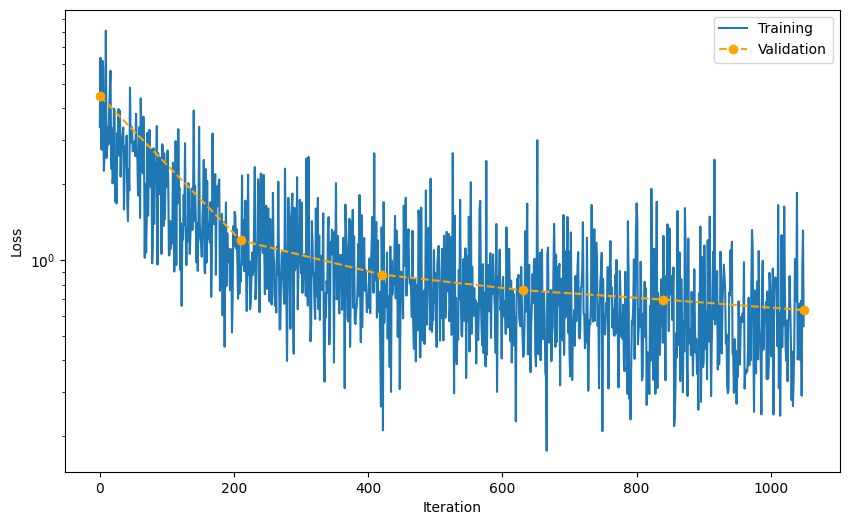

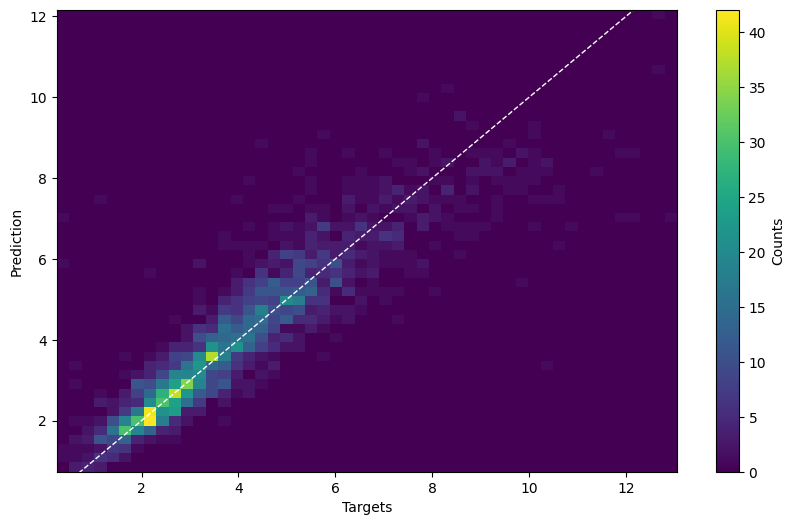

In [38]:
num_epochs=5
train_sZ_spk.train(num_epochs)

train_sZ_spk.test("test")
print(f"Test loss: {train_sZ_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_sZ_spk.acc_hist['test'][num_epochs]*100}%")
train_sZ_spk.plot_loss()
train_sZ_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

## Y

In [39]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][2][1]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

(array([2.242e+03, 7.150e+03, 4.167e+03, 1.067e+03, 2.410e+02, 5.900e+01,
        1.000e+01, 5.000e+00, 0.000e+00, 1.000e+00]),
 array([1.45741235e-02, 1.85474813e+00, 3.69492197e+00, 5.53509617e+00,
        7.37526989e+00, 9.21544361e+00, 1.10556183e+01, 1.28957920e+01,
        1.47359657e+01, 1.65761395e+01, 1.84163132e+01]),
 <BarContainer object of 10 artists>)

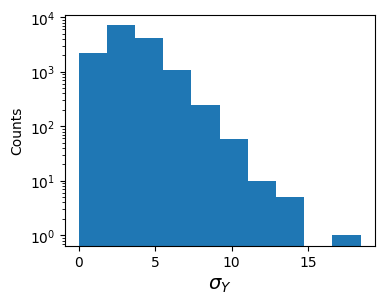

In [40]:
sigmaY = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(4, 3))
plt.xlabel(r'$\sigma_{Y}$', fontsize=14)
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(sigmaY)

In [41]:
net_sY_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

opt_sY_spk = torch.optim.Adam(net_sY_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_sY_spk = Trainer(net_sY_spk, loss_fn, opt_sY_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

Epoch 0:
Validation Loss = 2.4797430515289305
Validation Accuracy = 0.788451075553894

-------------------------------



Epoch:  20%|██        | 1/5 [00:30<02:01, 30.39s/it]

Epoch 1:
Validation Loss = 1.882010249296824
Validation Accuracy = 0.5739520788192749

-------------------------------



Epoch:  40%|████      | 2/5 [01:00<01:29, 29.98s/it]

Epoch 2:
Validation Loss = 1.813819150129954
Validation Accuracy = 0.5836085677146912

-------------------------------



Epoch:  60%|██████    | 3/5 [01:29<00:59, 29.76s/it]

Epoch 3:
Validation Loss = 1.696038970682356
Validation Accuracy = 0.4935539960861206

-------------------------------



Epoch:  80%|████████  | 4/5 [01:59<00:29, 29.64s/it]

Epoch 4:
Validation Loss = 1.6412529812918768
Validation Accuracy = 0.47009575366973877

-------------------------------



Epoch: 100%|██████████| 5/5 [02:28<00:00, 29.65s/it]

Epoch 5:
Validation Loss = 1.6157267583741082
Validation Accuracy = 0.45960015058517456

-------------------------------



Test loss: 1.881397799650828
Test relative error: 34.21242141723633%


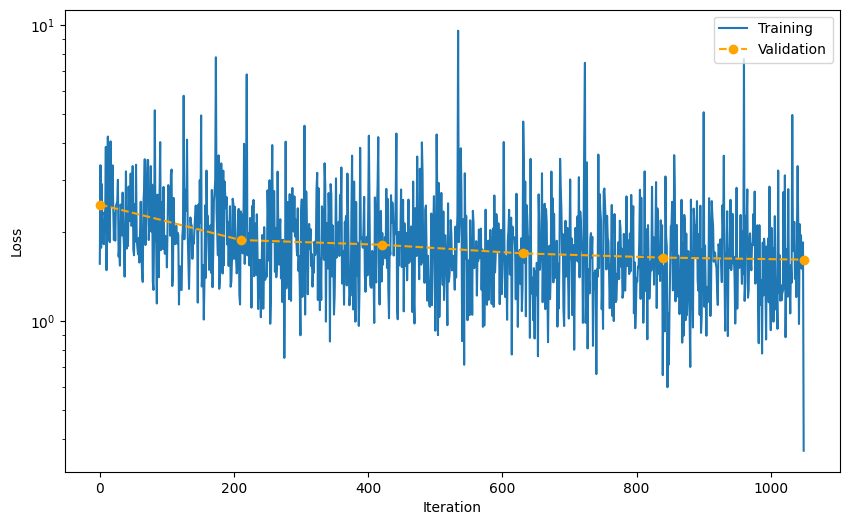

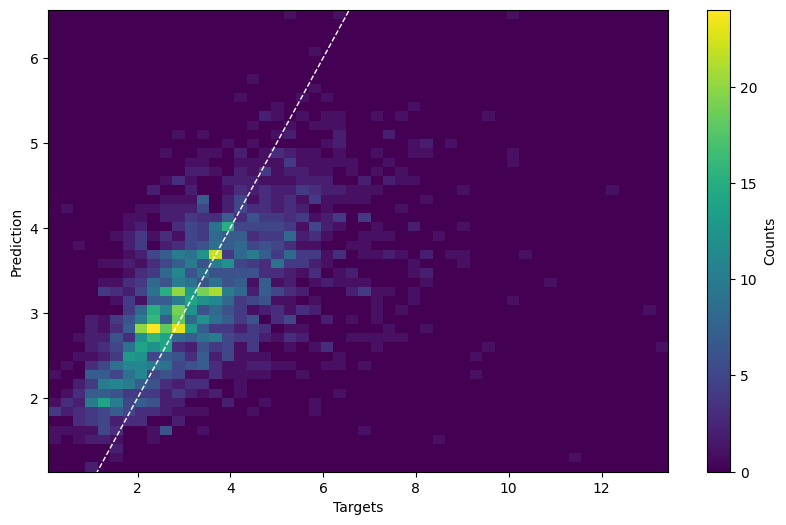

In [42]:
num_epochs=5
train_sY_spk.train(num_epochs)

train_sY_spk.test("test")
print(f"Test loss: {train_sY_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_sY_spk.acc_hist['test'][num_epochs]*100}%")
train_sY_spk.plot_loss()
train_sY_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

# Energy Regression + Y Position

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly2",  primary_only=True, target="energy",
                                                   transform=lambda x: (x[0], ds.to_tensor_and_dtype(np.log10(x[1]), torch.float32)))

batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
def spikegen_multi(data, multiplicity=4):
    og_shape = data.shape
    spike_data = torch.zeros(og_shape[1], og_shape[0], multiplicity*og_shape[2])
    for i in range(multiplicity):
        condition = data > np.power(10, i+2)
        batch_idx, time_idx, sensor_idx = torch.nonzero(condition, as_tuple=True)
        spike_data[time_idx, batch_idx, multiplicity*sensor_idx+i] = 1

    return spike_data

def spikegen_with_position(data, *args, **kwargs):
    spk1 = spikegen_multi(data, *args, **kwargs)
    spk2 = net_y(data)

    output = torch.cat((spk1, spk2), dim=2)

    return output


population = 10
net_desc_spikefreq_with_pos = {
    "layers" : [410, 200, population],
    "timesteps": 100,
    "output": "membrane",
    "neuron_params" : {
                1: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True,
                    "spike_grad": surrogate.fast_sigmoid(),
                    }],
                2: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True, 
                    "spike_grad": surrogate.fast_sigmoid(),
                    }]
                }
    }

net_E = Spiking_Net(net_desc_spikefreq_with_pos, lambda x: spikegen_with_position(x,4))

optimizer_E = torch.optim.Adam(net_E.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net_E = Trainer(net_E, loss_fn, optimizer_E, train_load, val_load, test_load, predict_spikefreq)
    

In [ ]:
num_epochs=10
train_net_E.train(num_epochs)

train_net_E.test("test")
print(f"Test loss: {train_net_E.loss_hist['test'][10]}")
print(f"Test relative error: {train_net_E.acc_hist['test'][10]*100}%")
train_net_E.plot_loss()
train_net_E.plot_pred_vs_target(50, logscale=False, linthresh=1)

In [ ]:
def antitransform(x):
    return torch.pow(10, x)

train_net_E.test("test", transform=antitransform)
print(f"Test loss: {train_net_E.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net_E.acc_hist['test'][num_epochs]*100}%")
train_net_E.plot_pred_vs_target(50, transform=antitransform, logscale=True, linthresh=1)

In [ ]:
net_E.eval()
all_x = []
all_predictions = []
with torch.no_grad():
    for data, targets in test_load:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        output = net_E(data)
        # calculate total accuracy
        pred, acc = predict_spikefreq(output, targets, antitransform)
        all_predictions.extend(pred.tolist())
        all_x.extend(data.sum((1,2)).tolist())
        
fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel("Photon Count")
plt.ylabel("Energy Prediction [MeV]")
plt.hist2d(all_x, all_predictions, 50, norm=SymLogNorm(linthresh=1), cmap='viridis')
# Add a color bar
plt.colorbar(label='Counts')
plt.plot([0, 1e5], [0, 1e5], color='white', linewidth=1, linestyle='--')

# N of interactions

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly", max_files=5, target="N_int",
                                                   transform= lambda x: (x[0], ds.to_tensor_and_dtype(x[1], torch.float32)))

In [ ]:
batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
Nint = ((np.array([d[1] for d in data_train])))

fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel(r'$\sigma_{E}$', fontsize=14)
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(Nint)


In [ ]:
min(Nint)

In [ ]:
idx = 15
print(Nint[idx])
visualize.plot_views(idx, data_train)

# OLD

In [ ]:
class Net_LIF_1L(nn.Module):
    """FCN with 1 hidden layer and LIF neurons."""

    def __init__(self, input_feat, hidden, out_feat, timesteps,
                 learnable=True, beta=0.8, threshold=1.0):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = out_feat              # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network

        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                learn_beta=learnable, learn_threshold=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                 learn_beta=learnable, learn_threshold=learnable)
        
    def _spikegen(self, data):
        spike_data = data.transpose(0,1) 
        spike_train = torch.where(spike_data > 300, torch.tensor(1), torch.tensor(0)).to(torch.float32) 
        return spike_train
    
    def forward(self, data):
        """Forward pass for several time steps."""

        x = self._spikegen(data)

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0)

In [ ]:
class Net_Reg(nn.Module):
    """FCN with 1 hidden layer and LIF neurons."""

    def __init__(self, input_feat, hidden, timesteps,
                 learnable=True, beta=0.8, threshold=1.0):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = 1                     # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network

        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                learn_beta=learnable, learn_threshold=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=1e20,
                                 learn_beta=learnable)
        
    def _spikegen(self, data):
        spike_data = data.transpose(0,1) 
        spike_train = torch.where(spike_data > 300, torch.tensor(1), torch.tensor(0)).to(torch.float32) 
        return spike_train
    
    def forward(self, data):
        """Forward pass for several time steps."""

        x = self._spikegen(data)

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return  mem2_rec[-1].squeeze(1)

In [ ]:
#loss = nn.MSELoss()
num_inputs = 100
num_hidden = 200
num_steps = timesteps
net2 = Net_Reg(num_inputs, num_hidden, num_steps)

In [ ]:
def accuracy_set(net, data_loader, loss_fn, comp_mc=False):
    mcm = MulticlassConfusionMatrix(num_classes=nClasses, normalize='none')
    net.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        temp_loss = []
        for data, targets in data_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data)
            spike_in = spike_in.to(device)

            # forward pass
            output = net(spike_in)

            # compute loss
            loss = loss_fn(output, targets)
            temp_loss.append(loss.item())

            # calculate total accuracy
            tot, corr, pred = comp_accuracy(output, targets)
            total += tot
            correct += corr
            if comp_mc:
                mcm.update(pred, targets)

        mean_loss = np.mean(temp_loss)
        acc = correct/total

        return mean_loss, acc, mcm

In [ ]:
def train_net(net, train_loader, val_loader, num_epochs, loss_fn, optimizer, batch_size=100):

    net.to(device)
    
    loss_hist = []
    loss_val_hist = []
    acc_val_hist = []

    iter_counter = 0

    # Validation
    mean_loss_val, acc_val, _ = accuracy_set(net, val_loader, loss_fn, batch_size)

    loss_val_hist.append(mean_loss_val)
    acc_val_hist.append(acc_val)
    print(f"Validation Set Loss: {mean_loss_val}")
    print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
    print("\n--------------------------------------------------\n")

    for epoch in range(num_epochs):
        net.train()
        batch_counter = 0
        # Minibatch training loop
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data)
            spike_in = spike_in.to(device)

            # forward pass
            output = net(spike_in)

            # compute loss
            loss_val = loss_fn(output, targets)
        
            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())
        
            if iter_counter % 50 == 0:
                print("Epoch:", epoch+1)
                print("Batch:", batch_counter)
                print("Iteration:", iter_counter)
                print("Loss:", loss_val.item(),"\n")
        
            batch_counter += 1
            iter_counter += 1

        # Validation
        mean_loss_val, acc_val, _ = accuracy_set(net, val_loader, loss_fn, batch_size)

        loss_val_hist.append(mean_loss_val)
        acc_val_hist.append(acc_val)
        print(f"Validation Set Loss: {mean_loss_val}")
        print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
        print("\n--------------------------------------------------\n")

    return loss_hist, loss_val_hist, acc_val_hist

In [ ]:
net = Net_LIF_1L(num_inputs, num_hidden, num_outputs, num_steps).to(device)
net.train()

In [ ]:
num_epochs = 5
iter_counter = 0

#loss = nn.MSELoss()
num_inputs = 100
num_hidden = 200
num_outputs = nClasses
num_steps = timesteps
net = Net_LIF_1L(num_inputs, num_hidden, num_outputs, num_steps).to(device)
loss_fn = SF.ce_count_loss(num_classes=nClasses)
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

res = train_net(net, train_load, val_load, num_epochs, loss_fn, optimizer, batch_size=100)

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(res[0])
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(res[1])
plt.title("Validation loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [ ]:
test = accuracy_set(net, test_load, loss_fn, True)
test[2].plot()

In [ ]:

for data, targets in train_load:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data)
            spike_in = spike_in.to(device)

            print(spike_in.shape)
            break